In [1]:
from IPython.core.display import HTML
display(HTML("""
<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>"""))

In [108]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import matplotlib as mpl
import dateparser
import datetime
import math
import folium
import requests
import json
import calmap
import scipy.cluster.hierarchy as sch
import glob
import warnings
import gzip
import datetime as dt
import matplotlib.cm as cm
import matplotlib.font_manager
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from scipy.spatial.distance import euclidean, cityblock
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ar
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from geopy.geocoders import Nominatim
from collections import Counter
from IPython.display import Image, display
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None


def plot_traffic():
    """Plots the traffic patterns for different days of the week"""
    data = pd.read_csv('waze.csv', nrows=50_000)
    data['blocks'] = data['blocks'].map(eval)
    data = data.explode('blocks')
    data.head(5)

    data['startTime'] = pd.to_datetime(data.startTime.str[:-10],
                                       format='%Y-%m-%d %H')
    data['startTime'] += dt.timedelta(hours=8)
    data['date'] = data.startTime.dt.date
    data['hour'] = data.startTime.dt.hour
    data['dayofweek'] = data.startTime.dt.dayofweek
    data['weekend'] = np.where((data.dayofweek == 5) | (data.dayofweek == 6),
                               1, 0)
    data['year'] = pd.DatetimeIndex(data['date']).year
    data['month'] = pd.DatetimeIndex(data['date']).month
    data['day'] = pd.DatetimeIndex(data['date']).day

    df = data[data['weekend'] == 1]
    df.hour.unique()
    data_2 = data[data['level'] < 5]

    df_level_day = data_2[data_2['weekend'] == 0].groupby('hour').mean()
    df_level_day['period'] = 'weekday'
    df_level_day = df_level_day.loc[:,['level']]

    df_level_end = data_2[data_2['weekend'] == 1].groupby('hour').mean()
    df_level_end['period'] = 'weekend'
    df_level_end = df_level_end.loc[:,['level']]

    dist_level = pd.concat([df_level_day,
                            df_level_end], axis=1).fillna(value=0)
    dist_level.columns = ['weekday', 'weekend']

    dist_level.plot(figsize=(15,7), xlabel='Hour',
                    ylabel='Ave. Traffic Level',
                    title='Ave. Traffic Level per Hour in Pasig City',)
    
    
def scrape_weather_wwo():
    """Scrape weather data using API"""
    #Dates to scrape
    dates = pd.date_range('2018-01-01','2021-08-30' , 
                          freq='1M')-pd.offsets.MonthBegin(1)
    enddates = pd.date_range('2018-02-28','2021-09-02' , 
                             freq='1M')-pd.offsets.MonthEnd(1)
    enddate_list = enddates.strftime("%Y-%m-%d").tolist()
    startdate_list = dates.strftime("%Y-%m-%d").tolist()
    enddate_list.append('2021-08-31')
    startdate_list.append('2021-08-01')

    #API
    API_KEY = '4b69c33e21fc4877a58102017210209'
    df = pd.DataFrame()
    for startmonth, endmonth in zip(startdate_list, enddate_list):
        data = requests.get(
        'http://api.worldweatheronline.com/premium/v1/past-weather.ashx',
        params={
            'key': API_KEY,
            'q': 'Quezon City',
            'date': startmonth, 
            'enddate' : endmonth,
            'tp' : 1,
            'data' : 'weather',
            'format': 'json'}).json()
        filename = startmonth + "_" + endmonth + "_" + "hr" ".json"
        with open(filename, 'w') as f:
            json.dump(res, f)

        for day in range(len(data['data']['weather'])):
                date = data['data']['weather'][day]['date']
                for hour_time in (range(len(data['data']['weather']
                                            [day]['hourly']))):
                    time = (data['data']['weather'][day]['hourly']
                            [hour_time]['time'])
                    tempc = (data['data']['weather'][day]['hourly']
                             [hour_time]['tempC'])
                    humidity = (data['data']['weather'][day]['hourly']
                                [hour_time]['humidity'])
                    precipmm = (data['data']['weather'][day]['hourly']
                                [hour_time]['precipMM'])
                    windspeedkmph = (data['data']['weather'][day]
                                     ['hourly'][hour_time]['windspeedKmph'])
                    visibility = (data['data']['weather'][day]
                                  ['hourly'][hour_time]['visibility'])
                    pressure = (data['data']['weather'][day]['hourly']
                                [hour_time]['pressure'])
                    cloudcover = (data['data']['weather'][day]
                                  ['hourly'][hour_time]['cloudcover'])
                    heatindexC = (data['data']['weather'][day]
                                  ['hourly'][hour_time]['HeatIndexC'])
                    dewpointC = (data['data']['weather'][day]
                                 ['hourly'][hour_time]['DewPointC'])
                    windchillC = (data['data']['weather'][day]
                                  ['hourly'][hour_time]['WindChillC'])
                    windgustkmph = (data['data']['weather'][day]['hourly']
                                    [hour_time]['WindGustKmph'])
                    uvindex = (data['data']['weather'][day]
                               ['hourly'][hour_time]['uvIndex'])
                    df_row = pd.DataFrame({'date' : date,
                          'time': time,
                          'tempc' : tempc,
                          'precipmm' : precipmm,
                            'humidity': humidity,
                        'windspeedkmph': windspeedkmph,
                        'visibility' : visibility,
                            'pressure' : pressure,
                            'cloudcover' : cloudcover,
                            'heatindexC' : heatindexC,
                            'dewpointC' : dewpointC,
                            'windchillC' : windchillC,
                            'windgustkmph' : windgustkmph,
                            'uvindex' : uvindex}, index=[0])
                    df = pd.concat([df, df_row])

    df.to_csv('WWO_weather_final_hr.csv')


def merge_weather_df():
    """Merge the DataFrames for each weather dataset"""

    wwo = pd.read_csv('../data/World Weather Online/WWO_weather_final_hr.csv')
    time = wwo['time'].values
    time_new = []
    for i in time:
        if i == 0:
            time_new += [0]
        else:
            time_new += [int(str(i)[:-2])]
    wwo['time_new'] = time_new
    wwo['datetime'] = pd.to_datetime(wwo.date) + pd.to_timedelta(wwo.time_new,
                                                                 unit='h')
    wwo.index = wwo['datetime']
    date_index2 = pd.date_range(start='2019-04-01',
                                end='2021-07-31', closed=None,freq='H')
    wwo_new = wwo.reindex(date_index2).copy()
    wwo_new.fillna(method="ffill",inplace=True)
    time_date = pd.read_csv('/mnt/processed/private/msds2022/lt12/'
                            'DMW Final Project/weather_pasig.csv')
    dates2 = [i.split(',')[0].strip() for i in list(time_date.ds.values)]
    time_date['dates_day'] = dates2
    time_date.dates_day = time_date.dates_day.map(dateparser.parse)
    time_ = list(time_date['ts'])
    time_new_ = []
    for i in time_:
            time_new_ += [int(i[:2])]
    date_index2 = pd.date_range(start='2010-01-01', end='2021-08-26',
                                closed=None,freq='H')
    time_date_new = time_date.reindex(date_index2).copy()
    time_date_new.fillna(method="ffill",inplace=True)

    time_date_new['datetime'] = time_date_new.index
    wwo_final = wwo.reset_index(level=0, drop=True).copy()
    time_date_final = time_date_new.reset_index(level=0, drop=True).copy()
    df_weather = wwo_final.merge(time_date_final,
                                 how='inner',
                                 on='datetime').copy()
    return df_weather
    
    
def plot_hist_rain():
    """Plot daily rainfall for every year"""
    df_weather2 = pd.read_csv('df_weather.csv')
    df_day_precip_std = df_weather2.groupby('date')['precipmm_std'].sum()
    plt.figure(figsize=(15,8))
    df_day_precip_std.index = pd.to_datetime(df_day_precip_std.index)
    df_day_precip_std[df_day_precip_std.index.year == 2018].hist(alpha = 0.4, 
                                                    bins = 50, label = 2018)
    df_day_precip_std[df_day_precip_std.index.year == 2019].hist(alpha = 0.4, 
                                                    bins = 50, label = 2019)
    df_day_precip_std[df_day_precip_std.index.year == 2020].hist(alpha = 0.4, 
                                                    bins = 50, label = 2020)
    df_day_precip_std[df_day_precip_std.index.year == 2021].hist(alpha = 0.4, 
                                                    bins = 50, label = 2021)
    plt.title('Histogram of daily rainfall in mm', fontsize = 20);
    plt.xlim(0,70)
    plt.legend();


def bucket_rain(mm):
    """Assign rain classification"""
    if mm == 0:
        return 'dry'
    if mm < 2.5: 
        return 'drizzle'
    if mm < 7.5: 
        return 'rain'
    if mm >= 7.5:
        return 'heavyrain'

    
def plot_rain_classification():
    """Plot frequency per rain classification"""
    df_weather2 = pd.read_csv('df_weather.csv')
    df_weather2['precipmm_std'] = df_weather2['precipmm_std'].astype(float)
    df_weather2['rain_classification_std'] = (df_weather2['precipmm_std']
                                              .apply(bucket_rain))
    df_rain_class=df_weather2.groupby('date')['rain_classification_std'].max()
    df_rain_class = df_rain_class.reset_index()
    df_rain_class['year'] = df_rain_class['date'].astype(str).str[:4]
    sns.set(font_scale = 1.5)
    sns.catplot(x="year", hue="rain_classification_std", 
                    data=df_rain_class, kind="count", height=8, 
                aspect=15/8).set(title='Frequency per rain ' 
                                      'classification');
    
def plot_calendar_rain():
    """Plot total rainfall daily in calendar format"""
    
    df_weather2 = pd.read_csv('df_weather.csv')
    df_day_precip = df_weather2.groupby('date')['precipmm_std'].sum()
    df_day_precip.index = pd.to_datetime(df_day_precip.index)
    fig, ax = calmap.calendarplot(df_day_precip, fig_kws={"figsize":(36,15)}, 
                                  fillcolor='grey', cmap = 'Blues')
    fig.suptitle("Total Rainfall Daily" , y = 1.01, weight = 'bold', 
                 fontsize = 25);
    mpl.rcParams['font.family'] = 'DejaVu Sans'


def plot1(Z):
    """Accepts the output of linkage and replicates the plot"""
    fig, ax = plt.subplots(figsize=(12,4), dpi=300)
    dendrogram = sch.dendrogram(Z, truncate_mode='level',p=5)
    plt.title('Traffic Clusters')
    plt.xlabel('')
    plt.ylabel(r'$\Delta$')
    plt.show()
    return ax


def convert_to_blocks(filepaths):
    """Clean and vectorize jams from linestrings to blocks"""
    jams_lookup = pd.Series()
    for filepath in filepaths:
        print('')
        print(filepath)
        for df in pd.read_json(filepath,
                               orient='records',
                               lines=True,
                               chunksize=2E5):
            print('.', end='')
            df = df.drop(['type',
                          'startTimeMillis',
                          'uuid', 'street',
                          'city'], axis=1)
            df['line'] = df.line.map(str)
            jams = df[['line', 'length']].drop_duplicates()
            jams = jams[~jams.line.isin(jams_lookup.index)]
            jams.index = jams['line'].values.copy()
            jams['line'] = jams.line.map(eval).map(
                lambda line: shapely.geometry.linestring.LineString(
                    [list(pt.values()) for pt in line]))
            jams['line'] = jams.apply(lambda jam: [
                jam.line.interpolate(dist).xy for dist in np.linspace(
                    0, 1, jam.length//4+2)], axis=1)
            jams['blocks'] = jams['line'].map(
                lambda line: list(set(
                    [tuple(np.round(pt, 3).flatten()) for pt in line])))
            jams_lookup = jams_lookup.append(jams['blocks'])
            df = df.join(jams_lookup.to_frame(name='blocks'), on='line')
            del df['line']
            df['startTime'] = df.startTime.str[:-7]
            df = df[df.speed>0]
            df['speed'] = df['speed']*3.6
            df.to_csv('waze.csv.gz',
                      compression='gzip',
                      index=False, mode='a', header=False)


def waze_dataset(nrows):
    """Reads the csv file 'waze.csv.gz' and adds datetime features
    
    Parameters
    ----------
    nrows = integer
        Total # of rows to get in the dataset
    
    Returns
    -------
    df : pd.DataFrame
        Returns a pandas DataFrame of the waze dataset with datetime features
    """
    df = pd.read_csv('waze.csv.gz', nrows=nrows)
    df['blocks'] = df.blocks.map(eval)
    df = df.explode('blocks')

    df['startTime'] = pd.to_datetime(df.startTime.str[:-10],
                                     format='%Y-%m-%d %H')
    df['startTime'] += datetime.timedelta(hours=8)
    df['date'] = df.startTime.dt.date
    df['hour'] = df.startTime.dt.hour
    df['dayofweek'] = df.startTime.dt.dayofweek
    df['weekend'] = np.where((df.dayofweek == 5) | (df.dayofweek == 6), 1, 0)
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    return df


def merge_waze_weather(df_waze):
    """Merges the waze and weather dataset
    
    Parameters
    ----------
    df_waze : pd.DataFrame
        The waze dataset
        
    Returns
    -------
    merged_df : pd.DataFrame
        Returns the merged waze and weather dataset
    """
    df_weather = pd.read_csv('df_weather.csv')
    df_weather['rain_bucket'] = df_weather.precipmm.map(bucket_rain)
    merged_df = df_waze.merge(df_weather, on=['year', 'month', 'day'])
    merged_df['level_squared'] = merged_df.level**2
    merged_df['month'] = merged_df['month'].apply(
        lambda x: '{0:0>2}'.format(x))
    merged_df['year-month'] = (merged_df['year'].astype(str) 
                            + '-' 
                            + merged_df['month'].astype(str))
    return merged_df


def bucket_rain(mm):
    """Assign rain classification"""
    if mm == 0:
        return 'dry'
    if mm < 2.5: 
        return 'drizzle'
    if mm < 7.5: 
        return 'rain'
    if mm >= 7.5:
        return 'heavyrain'
    

def reverse_geo(df):
    """Returns the road name based on latitute and longitude"""
    if ~any(df.columns.isin(['lat', 'lon'])):
        df['lat'] = df.blocks.str[1]
        df['lon'] = df.blocks.str[0]
        df['coor'] = df.lat.astype(str) + ', ' + df.lon.astype(str)
    else:
        pass
        
    road = []
    for i in df.coor:
        locator = Nominatim(user_agent='myGeocoder')
        location = locator.reverse(i)
        if 'road' in location.raw['address']:
            road.append((i,location.raw['address']['road']))
        else:
            pass

    road_df = pd.DataFrame(road, columns=['coor', 'road'])
    return road_df


def seasonality_plot(merged_df, rainbucket=False):
    """Plots the seasonality trend of the Weather in Pasig City

    Parameters
    ----------
    merged_df : pd.DataFrame
        Merge waze and weathers dataset
    rainbucket : boolean
        If 'True', it plots the seasonality trend with respect to the
        rainbucket, else 'False', it plots the seasonality trend of the
        weather

    Returns
    -------
    Returns the seasonality trend of the weather in Pasig City
    """
    if rainbucket:
        df = merged_df.groupby(
        ['date', 'year-month', 'desc', 'rain_bucket'],
            as_index=False)['level'].count()

    else:
        df = merged_df.groupby(
            ['date', 'year-month', 'desc'], as_index=False)['level'].count()

    df = df.drop(['date', 'level'], axis=1)
    seasonality = df.value_counts() \
                    .reset_index() \
                    .rename(columns={0: '_count'})

    if rainbucket:
        seasonality_plot = seasonality.pivot_table(index='year-month',
                                                   columns='rain_bucket',
                                                   values='_count',
                                                   fill_value=0)
        # Seasonality plot
        seasonality_plot.plot(
            figsize=(15,7), xlabel='Month', ylabel='Count',
            title='Seasonality Trend of Weather in Pasig City')
        plt.show()

    else:
        seasonality_plot = seasonality.pivot_table(
            index='year-month', columns='desc', values='_count', fill_value=0)

        # Seasonality plot
        seasonality_plot.plot(
            figsize=(15,7), xlabel='Month', ylabel='Count',
            title='Seasonality Trend of Weather in Pasig City')
        plt.show()


def hourly_heatmap(merged_df):
    """Creates a heatmap of the traffic level by hour in Pasig City of the Top
    25 roads

    Parameters
    ----------
    merged_df : pd.DataFrame
        Merged waze and weather dataset

    Returns
    -------
    Returns a heatmap of the traffic level by hour in Pasig City of the
    Top 25 roads
    """
    df = merged_df[['blocks', 'hour', 'level', 'level_squared']].copy()
    heat_df = df.groupby(['blocks', 'hour'], as_index=False).mean() 
    heat_df['new_level'] = heat_df['level_squared'] / heat_df['level']
    heat_df = heat_df.drop(['level', 'level_squared'], axis=1)
    heat_df['lat'] = heat_df.blocks.str[1]
    heat_df['lon'] = heat_df.blocks.str[0]
    heat_df['coor'] = heat_df.lat.astype(str) + ', ' + heat_df.lon.astype(str)

    count_df = Counter(heat_df.blocks)
    top25 = sorted(count_df.items(),
                   key=lambda x: (x[1], x[0]), reverse=True)[:25]
    top25 = [i[0] for i in top25]
    final_df = heat_df[heat_df.blocks.isin(top25)]
 
    heatg_df = reverse_geo(final_df).copy()

    heatmap_df = final_df.merge(heatg_df.copy(), on='coor')
    heat_pivot = heatmap_df.pivot_table(
        index='road', columns='hour', values='new_level', fill_value=0)
    fig, ax = plt.subplots(figsize=(15,7))
    sns.heatmap(heat_pivot, cmap="YlOrBr")
    plt.title('Traffic Level by hour in Pasig City')
    plt.show()


def geo_plot(merged_df, plot_type):
    """Makes a geographical scatter or heatmap of the roads that are affected
    by traffic due to heavyrain

    Parameters
    ----------
    merged_df : pd.DataFrame
        Merged waze and weater dataset
    plot_type : string
        Either 'Scatter' or 'Heatmap'

    Returns
    -------
    imap : Folium.map
        Returns a geographical scatter plot or heatmap of the roads that are
        affected by traffic due to heavyrain
    """
    heavy_rain = merged_df[merged_df.rain_bucket == 'heavyrain']
    heavyrain_df = heavy_rain.groupby('blocks', as_index=False)[
        ['speed', 'delay', 'level']].mean().sort_values(by=['level', 'delay'],
                                               ascending=[False, False])
    heavyrain_df.level = round(heavyrain_df.level).astype(int)
    heavyrain_df = heavyrain_df[heavyrain_df.level != 5]
    heavyrain_df['lat'] = heavyrain_df.blocks.str[1]
    heavyrain_df['lon'] = heavyrain_df.blocks.str[0]
    heavyrain_df = heavyrain_df.drop('blocks', axis=1)

    color = {
        0: 'green',
        1: 'yellow',
        2: 'orange',
        3: 'red',
        4: 'darkred'
    }

    heavyrain_df['color'] = heavyrain_df.level.map(color)
    imap = folium.Map(location=[
        heavyrain_df.lat.mean(), heavyrain_df.lon.mean()], zoom_start=10)
    if plot_type == 'Scatter':
        level = [folium.FeatureGroup(
                    name='<span style="color: {col};">{txt}</span>'.format(
                        txt='Level1', col='yellow')),
                 folium.FeatureGroup(
                     name='<span style="color: {col};">{txt}</span>'.format(
                         txt='Level2', col='orange')),
                 folium.FeatureGroup(
                     name='<span style="color: {col};">{txt}</span>'.format(
                         txt='Level3', col='red')),
                 folium.FeatureGroup(
                     name='<span style="color: {col};">{txt}</span>'.format(
                         txt='Level4', col='darkred'))]

        for i, j in zip(level, [1, 2, 3, 4]):
            heatmap_df = heavyrain_df[heavyrain_df.level == j]
            for lat, lon, level, color in zip(heatmap_df.lat,
                                              heatmap_df.lon,
                                              heatmap_df.level,
                                              heatmap_df.color):
                i.add_child(folium.Circle(location=[lat, lon],
                                           radius=50, weight=3,
                                           opacity=level,
                                           color=color, fill=True))
            imap.add_child(i)
        imap.add_child(folium.map.LayerControl())
        return imap

    elif plot_type == 'Heatmap':
        heat_data = [[lat, lon] for lat, lon in zip(heavyrain_df['lat'],
                                                    heavyrain_df['lon'])]
        HeatMap(heat_data).add_to(imap)
        return imap

    else:
        raise ValueError('plot_type should either be Scatter or Heatmap')

        
def mapper_dry_vs_rainy(feature_compare='jam_speed_mean',
                        feature_plot='change_due_to_rain'):
    """Plot out features on a map"""
    features = pd.read_csv('features_weather_new.csv.gz')
    blocks = pd.read_csv('blocks_before_screening.csv.gz')    
    blocks['dry'] = features[f'{feature_compare}_rain:dry']
    blocks['drizzle'] = features[f'{feature_compare}_rain:drizzle']
    blocks['heavy_rain'] = features[f'{feature_compare}_rain:heavyrain']
    blocks['rain_norm'] = blocks.heavy_rain/blocks.heavy_rain.mean()
    blocks['dry_norm'] = blocks.dry/blocks.dry.mean()
    blocks['change_due_to_rain'] =  blocks.rain_norm - blocks.dry_norm

    norm = mpl.colors.Normalize(vmin=blocks[feature_plot].min(),
                                vmax=blocks[feature_plot].max())
    m = cm.ScalarMappable(norm=norm, cmap=cm.RdYlBu_r)
    
    imap = folium.Map(location=[
    blocks.lat.mean(), blocks.lon.mean()], zoom_start=14)
    
    for ix, block in blocks.iterrows():
        if not pd.isnull(block['change_due_to_rain']):
            imap.add_child(
                 folium.Marker(
                    location=[block['lat'], block['lon']],
                    icon = (folium.DivIcon(
                        html=f"""<div><svg><rect width="10" height="10",
                        opacity=".8",
                        fill="{mpl.colors.rgb2hex(m.to_rgba(
    block[feature_plot])[:3])}",
    stroke="black", "stroke-width"="1"</svg></div>"""))))
            
    return imap


#### Notice: All datasets affliated with Waze and Thinking Machines was not uploaded together with report for confidentiality purposes.

# **Weather or Not?** - An Analysis of Weather & Traffic Flow in Pasig City

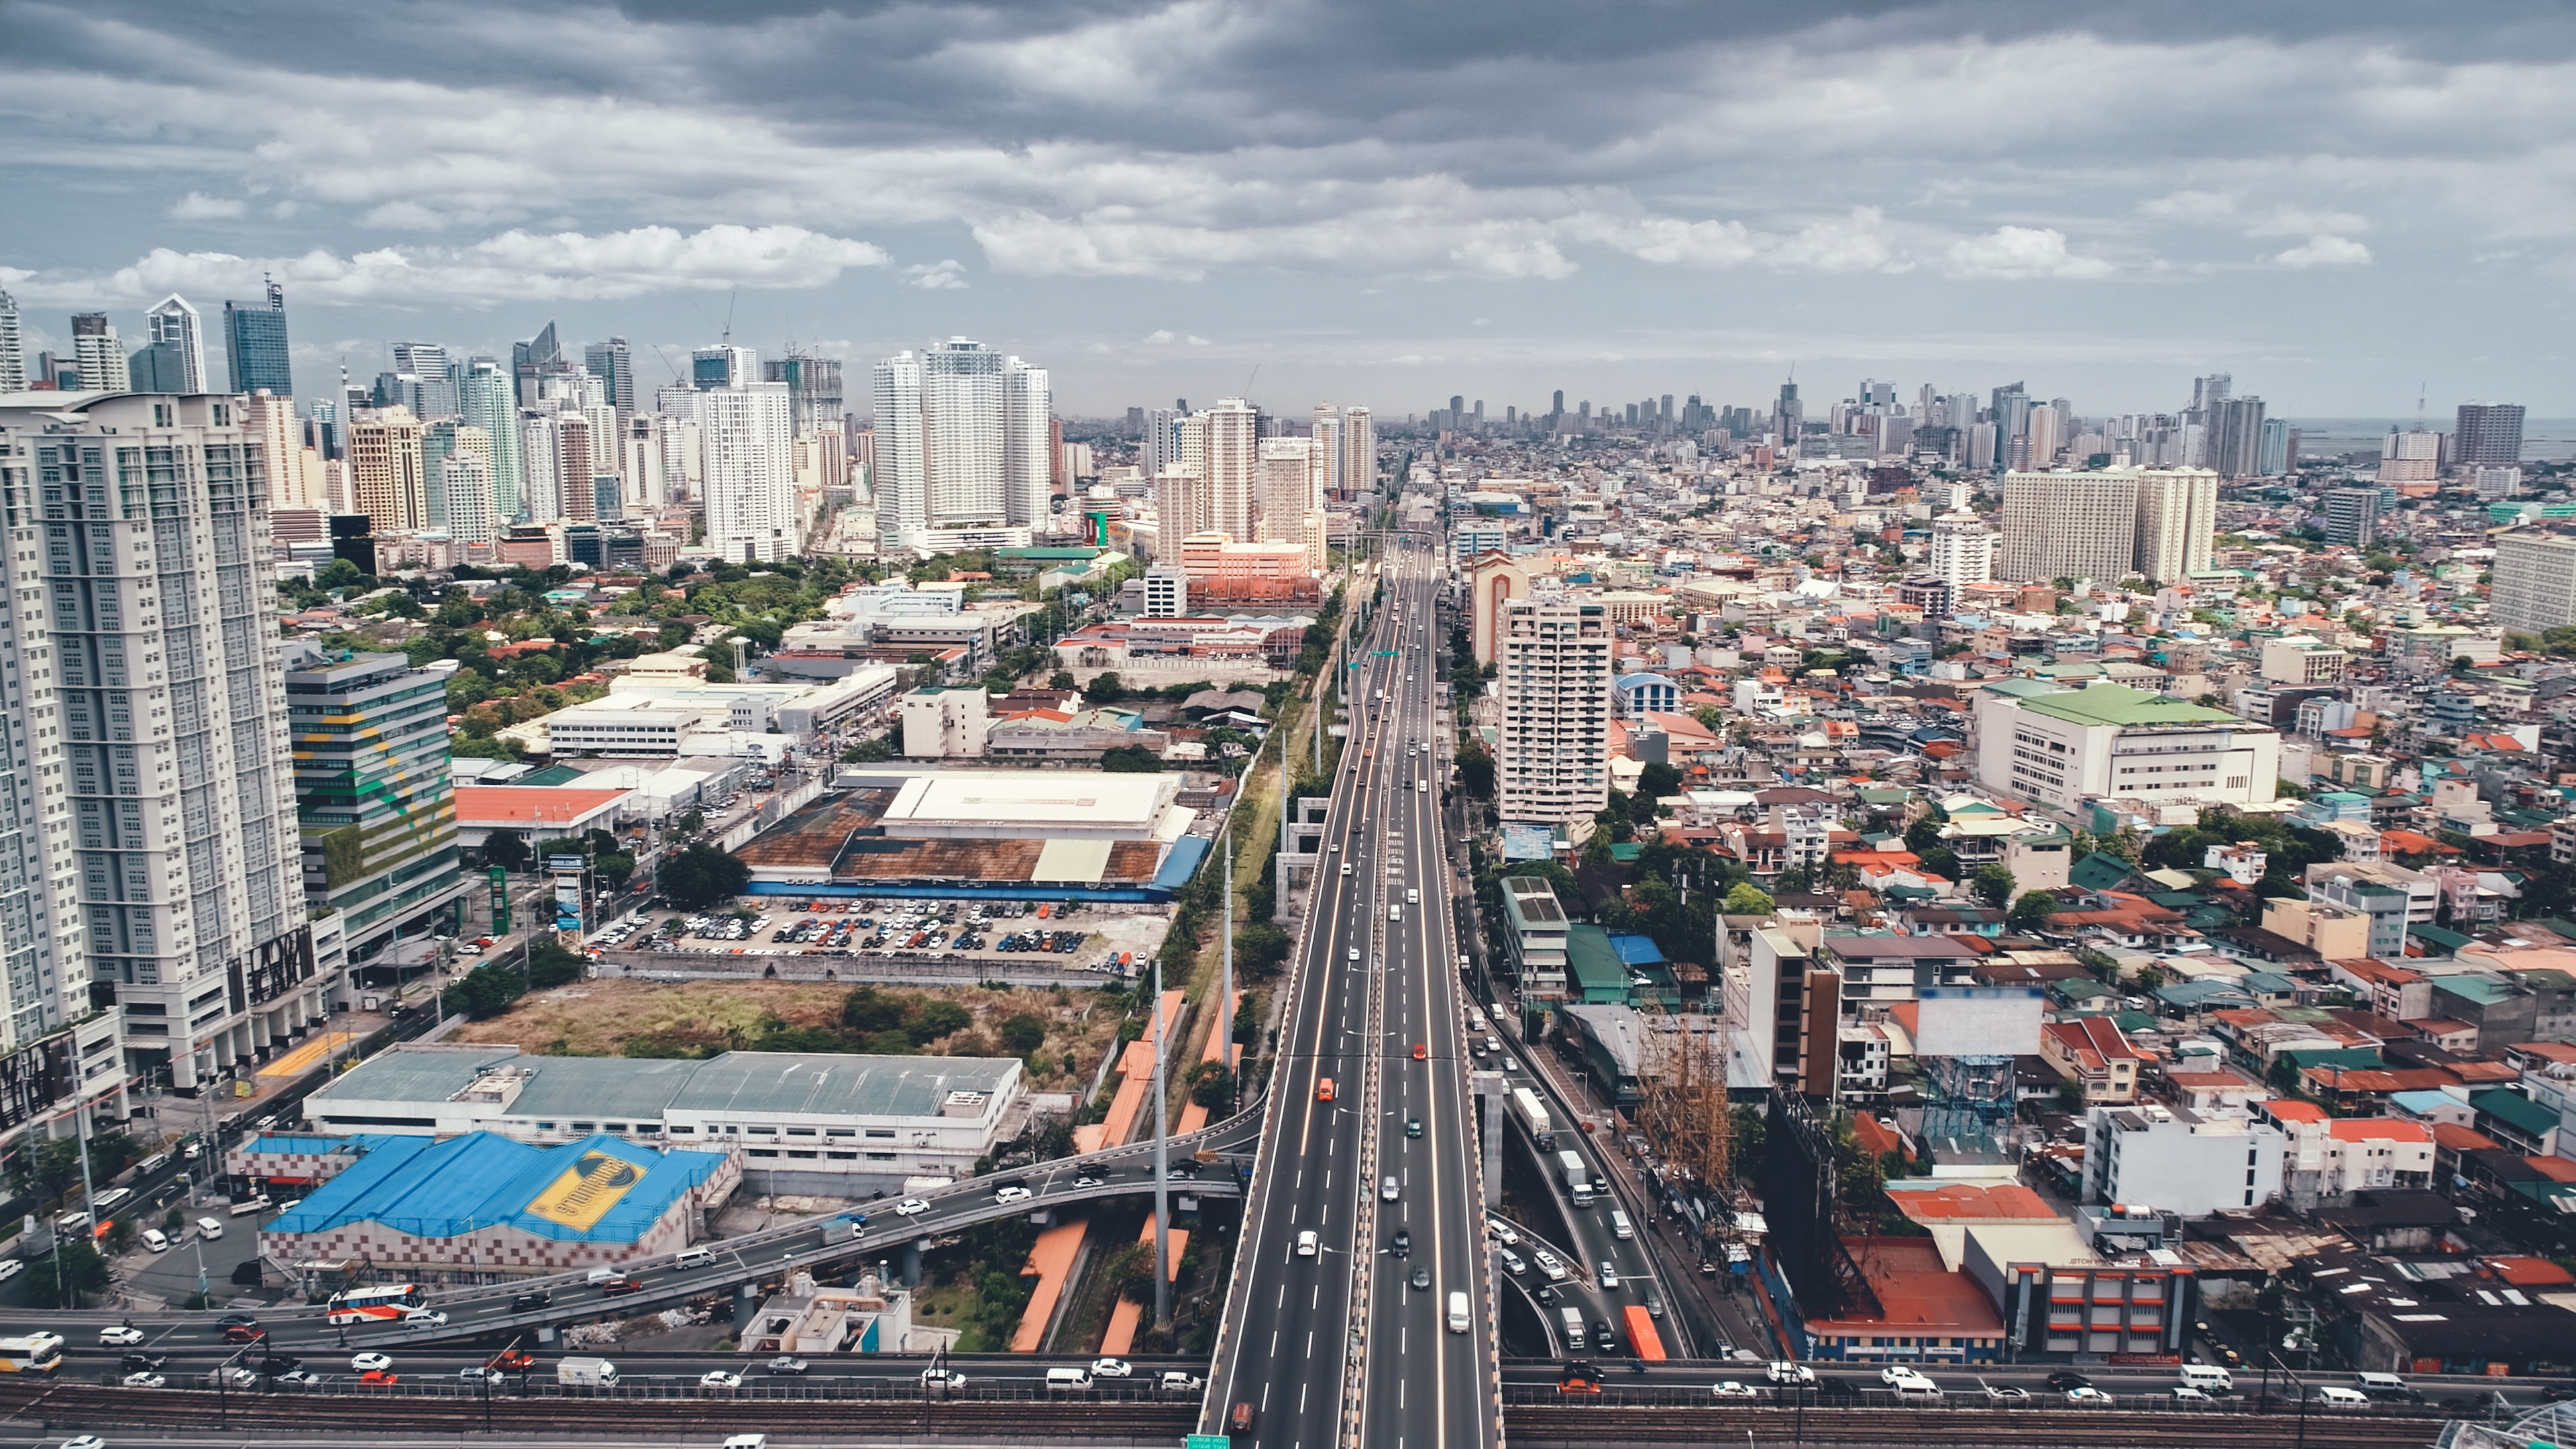

In [94]:
Image('Pasig City_.jpg')

# I. Executive Summary





The Philippines is one of the countries where autos are widely used as a form of travel. With roughly 154 thousand passenger cars sold in 2020, the Philippines is placed 11th among Asia and Pacific countries in terms of passenger car sales. With the increasing number of cars sold in the Philippines and the country's climate change, traffic is unavoidable and will increase over time. We try to address how the traffic flow in different areas of Pasig City responds to wet weather using data from the Waze Connected Citizens Program and weather data.

To help us investigate our problem, we examined both the weather and traffic data of Pasig City. For the weather data, we scraped both the TimeandDate weather API and WorldWeatherOnline website to derive weather features. On the other hand, we obtained externally-sourced Waze data to extract transport-related features such as traffic and location with help of Thinking Machines and the Waze Connected Citizens Program. To aid our analysis, we used vector representation to segment the Pasig City Waze Traffic into 700 square blocks with derived on traffic features (average speed, number of traffic jams, portions of road). Feature engineering was done to derive additional features such as the amount of rainfall in a certain span of of day/week/month/year to examine the effect of weather features for each block at different times. Each block was then grouped through the help of clustering. Additionally, dimensionality reduction was done to extract significant features. 

Upon clustering we were able to identify 3 main clusters according to their traffic volume and road type, and we decided to label them as routes:

Cluster 1: <b>Major Highways</b> includes roads guarantee you the fastest route with the highest potential speed, however because to the high volume of traffic and the route's length, most people will be significantly delayed along this route. This group includes major roadways. The Pasig City LGU and MMDA need to improve infrastructural capacity and traffic control in these locations, especially during severe weather.

Cluster 2: <b>Intracity Routes</b> contains roads that are ranked second in terms of weather-related delays, congestion, and speed. The majority of Pasig's areas fall into this category which indicates high urban congestion within the roads.

Cluster 3: <b>Hidden Routes</b> upon initial glance has roads which have the lowest maximum speed in the area that make them appear unpromising. However, they seem to be the smoothest and least congested routes. The majority of these are located in the outskirts of Pasig City. In times of congestion or inclement weather, the MMDA and Waze should guide drivers to these locations.
 
When we grouped clusters this way, we were able to reveal the city's various congested locations. The number of jams, maximum speed, and normalized delay for each block were the three most relevant characteristics in the clusters. All three are traffic characteristics that may be used to explain traffic congestion during different times of the day. As a consequence, we were able to decipher the clustering findings and glean useful information from the data.

Finally, we want to recommended the following to the relevant stakeholders of Pasig City and the National Government. First, we suggest increasing infrastructure capacity especially in Cluster 1 (Major Highways) to help in decreasing overall congestion among these roads especially since these are main thoroughfares. In the short-term, rerouting some of the traffic volume in the Main Highways to less-traversed roads such as those found in the third cluster (the Hidden Routes) may help in augmenting the congestion within the city during the rush hour. Lastly, for Cluster 2 (Intracity Routes), we suggest taking a closer a look at these areas for the crafting of long-term urban planning policies since points of interests such as commercial and public spaces are included here. In the process, this may improve the prospects of public transportation as well as route optimization and help in the overall traffic situation of Pasig in the future.

Recommendations to improve this study include expanding the dataset by integrating flood and accident reports, as well as possibly including non-jammed roads for a more complete picture of the traffic situation. This limitation could be augmented through twitter as well through NLP.
 

# II. Introduction

It is widely known but not quantified that rain and accompanying floods aggravate traffic. In fact, ADB dubbed Metro Manila as the most congested capital in 2019. Additionally, flooding in the region has been a persistent issue given the lack of proper infrastructure and preparation. Among these cities in the capital, Pasig City had some of the worst bottlenecks in the region according to the Metro Manila Development Authority (MMDA) and the continuous flooding incidents are known to aggravate the traffic.

Using the traffic data provided by the Waze Connected Citizens Program through Thinking Machines, and the weather data that was scraped from timeanddate.com and worldweatheronline.com, this report aims to determine how does the traffic flow in different areas of pasig city respond during the rainy weather and encourage more discussions on data-driven urban planning to assist LGUs in Disaster Risk Reduction & Traffic Management.

With the help of data from the Waze Connected Citizens Program and weather data, we try to answer the question, how the traffic flow in different areas in Pasig City respond during rainy weather?

# III. Motivation and Business Value

As Metro Manila continues to congest due to rising population albeit lacking infrastructure, our urban planners are constantly in pursuit of an optimal solution. As discussed earlier, quantitative methods in identifying and measuring the extent of the problem are lacking. As such, data-driven approaches to answer our congestion woes are also deficient. 

Data on traffic and its derivatives are abundant in the digital age; although not optimally utilized. For example, the MMDA has placed several cameras along the capital’s major thoroughfares, but it has yet to fully maximize it other than monitoring bottlenecks. We anticipate that research such as this should increase awareness of the availability of similar data sets such as with Waze. 

Lastly, the results from our study are not limited to urban planning. We also hope that our findings will better equip local government units (other than Pasig City) in disaster risk reduction and traffic management. Although urban planning solves congestion in the long run, we intend our study to benefit the current needs of any city.

# IV. Methodology

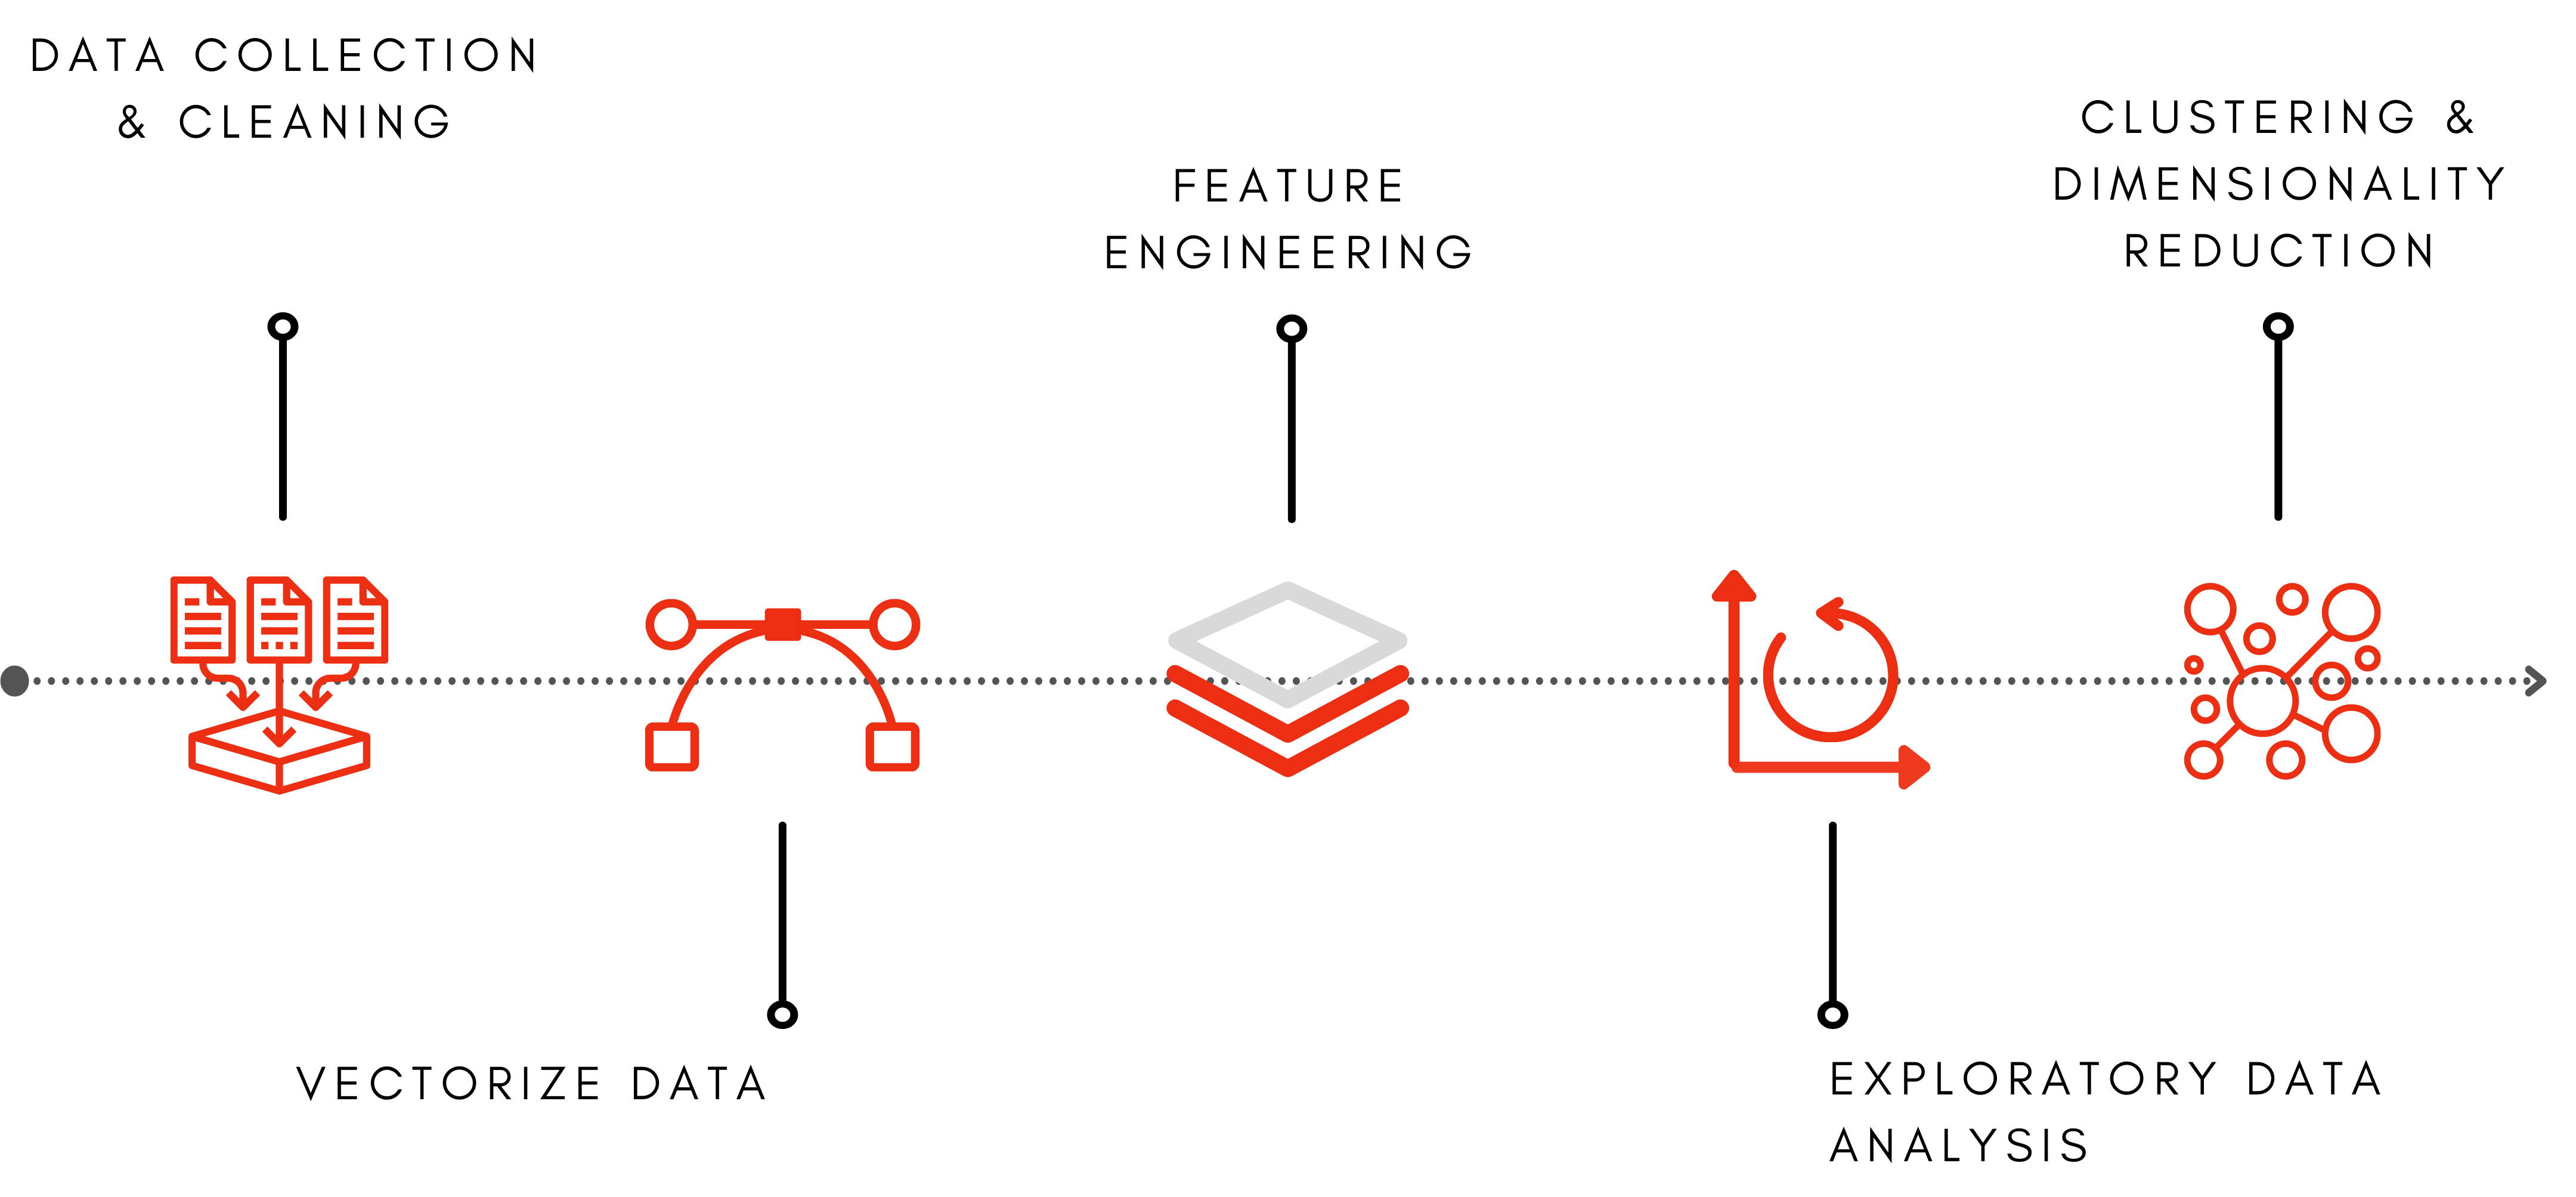

In [97]:
Image('Project_Methodology.png')

### 1. Data Collection and Cleaning 
For the weather features, we scraped the data from Time and Date API and World Weather Online website. For the traffic features and blocks, we obtained the data externally via the Waze Connected Citizens' Program and Thinking Machines. Both the traffic and weather datasets were cleaned accordingly.

### 2. Vectorize Data 
We created 700 traffic blocks (from coordinates) to represent Pasig City's based on areas of traffic.

### 3. Feature engineering
For the engineered traffic features, we mapped average speed, number of traffic jams, portions of road for each square block. Subsequently the engineered weather features generated included the amount of rainfall in a certain span of days/hours combined with the existing traffic features.

### 4. Exploratory Data Analysis (EDA)
For our EDA, we examined the trends for traffic, weather, and a combination of both over certain periods of time. We also analyzed the relationship between traffic and weather. 

### 5. Clustering and Dimensionality Reduction
For clustering, we performed Ward's Clustering so that we can better see how the smaller clusters were lumped together.
We then labeled the clusters appropriately based on locations and based on the features. In the process, we also applied dimensionality reduction to our dataset via Singular Value Decomposition (SVD) to interpret the significant features. 

# V. Data Collection and Cleaning 

## V.A Data Collection

### VI.A.1 Weather

For the weather data, we gathered scraped the WorldWeatherOnline and Timeanddate in hourly intervals. We limit the listed variables to the ones relevant to the study. 

The group collected weather data from 2 different sources since each source had different features:

- **[WorldWeatherOnline](https://www.worldweatheronline.com/quezon-city-weather-history/quezon-city/ph.aspx)**  

	The WorldWeatherOnline publishes weather data, including the amount of precipitation, in hourly intervals. However, there is no data specific to Pasig City. Thus, the group collected data for Quezon City, the nearest city from Pasig City, from 2018 to August 2021. The group used an API and the base `requests` to collect the data. We then used `BeautifulSoup`  to parse the results. We kept each month as a separate CSV file. 
    
    
- **[Timeanddate](https://www.timeanddate.com/weather/@7290466/historic)**
	Timeanddate publishes weather data in 6-hour intervals. While there is no data on the amount of precipitation, the dataset contains a description of the weather per interval. Data for Pasig City from 2009 to 2021 was collected using an API and the base `requests`. BeautifulSoup was also used to parse the results. We kept each month as a separate CSV file. 

### V.A.2 Traffic

For the traffic data, the team requested historical Waze jams data from Thinking Machines Data Science (TM). As a Waze Connected Citizens Partner, TM has been collecting traffic data on the entire country since 2018

The query used to extract data from the TM BigQuery dataset is below:

<img src="sql_query.PNG" style="width: 700px;"/>

We extracted three years of Pasig City jams as a 700MB compressed json.

## V.B Data Description

- We briefly present the different features from our datasets.

### V.B.1 Weather Data


<table style="width:100%">
  <tr>
    <th>Column</th>
    <th>Data Type</th>
    <th>Content</th>
  </tr>
 <tr>
    <td>precipmm_std</td>
    <td>float</td>
    <td>Adjusted amount of precipitation in mm</td>
  </tr>
 <tr>
    <td>'rain_classification_std'</td>
    <td>int</td>
    <td>Rain classification based on PAGASA’s definition. 0 if precipmm_std is at 0mm, 1 if greater than 0 but below 2.5mm, 2 if greater or equal to 2.5mm but less than 7.5mm, 3 if greater or equal to 7.5mm </td>
  </tr>
 <tr>
    <td>desc</td>
    <td>text</td>
    <td>Description of weather (i.e., Haze, Partly sunny, Overcast, Passing clouds, Light rain, etc.) </td>
  </tr>
</table> 


### V.B.2 Traffic Data

The extracted data is composed of 2.5M rows of jams with a temporal granularity of 2 minutes. The accompanying data dictionary is illustrated below:

![waze data dictionary](data_dict.PNG)
<p style="text-align: center; font-weight: bold;">Figure X. Waze data specifications


### V.C Data Cleaning


The following pre-processing steps were performed for the weather dataset.

1. To combine the weather datasets, we interpolated the data from Timeanddate into hourly intervals based on its previous value from the 6-hour interval. The Timeanddate and World Weather Online datasets were then merged on the hourly intervals. 

2. We noted that the data on the amount of precipitation from the WorldWeatherOnline dataset was understated since its annual precipitation level is at around 1,000mm or below. According to Climatemps, average annual precipitation level for Metro Manila is at 2,061mm. Thus, we adjust the rainfall data by dividing the hourly precipitation level by the fraction of the amount of rainfall for the year over 2,061. 

3. We added the rain classification per hourly interval based on PAGASA’s definition. 


In [18]:
pd.read_csv('df_weather.csv').head()

tempc  precipmm  humidity  windspeedkmph  visibility  pressure  cloudcover  \
0     25       0.0        73             14          10      1011          16   
1     25       0.0        73             15          10      1011          17   
2     25       0.0        74             15          10      1011          18   
3     25       0.0        74             15          10      1011          20   
4     25       0.0        72             17          10      1011          17   

   heatindexC  dewpointC  windchillC  ...  year        date  month  day  \
0          27         20          25  ...  2018  2018-01-01      1    1   
1          27         20          25  ...  2018  2018-01-01      1    1   
2          26         20          25  ...  2018  2018-01-01      1    1   
3          26         20          25  ...  2018  2018-01-01      1    1   
4          27         20          25  ...  2018  2018-01-01      1    1   

              datetime  std_weight  precipmm_std  rain_classification_std  \
0  2018-01-01 00:00:00    0.537069           0.0                        0   
1  2018-01-01 01:00:00    0.537069           0.0                        0   
2  2018-01-01 02:00:00    0.537069           0.0                        0   
3  2018-01-01 03:00:00    0.537069           0.0                        0   
4  2018-01-01 04:00:00    0.537069           0.0                        0   

   day_of_week  rain_classification  
0            0                    0  
1            0                    0  
2            0                    0  
3            0                    0  
4            0                    0  

[5 rows x 33 columns]

For data cleaning, we converted the timestamps from UTC to local and removed rows with speed=0 and delay=-1 because those signified road closures. Road closures persist for days to months at a time and keeping them would artificially inflate the number and total length of jams. 

The jam location was also restructured from a list of latitude-longitude dictionaries to a Linestring WKT. 
<img src="data0.png" style="width: 600px;"/>

<p style="text-align: center; font-weight: bold;">Figure X. A list of latitude-longitude dictionaries
<img src="data1.png" style="width: 600px;"/>
Figure X. Linestring WKT

# VI. Data Vectorization

Waze data comes in the form of a linestring with information attached to it. These linestrings range from tens to thousands of meters and are thus not directly comparable. We need to get them into a form that’s more consistent.

We decide on using square blocks 0.001 decimal degrees or ~170m per side. Doing a spatial join is a computationally expensive and slow process, so we hack a simpler solution.

We convert the linestrings into a list of square blocks by doing the following:
1. Interpolate a point every 20m along each linestring.
2. Truncate every point to three decimal degrees
3. Deduplicate the truncated points
4. Use `pd.explode` on the resulting list.

![vectorization code](vectorization.PNG)

# VII. Feature Engineering

Feature Engineering is the process of extracting features from raw data to include in the model. [1] We performed feature extraction on the Waze dataset and the scraped weather dataset. From there, we performed feature engineering to combine the two expanded datasets to produce a total of 2059 columns.


		


### VII.A. Waze Dataset


For each block representing a row, the features extracted included column-wise statistics such as the minimum, maximum, average, standard deviation of the jam speed. The count of jam speeds and unique road types were also features added. The mean and sum of delays were also calculated.

Interactions between other original features were included as well such as the mean jam speed multiplied by the mean delay determined to be similar to the length of the jam. For spatial features, the average and maximum of delay per jam length were also calculated as new features.

Next, these features were again further calculated temporally with varying granularity. These include month of the year, day of the week, hour of the week and if the day of occurrence was a weekday.

We get 1927 new columns from this extraction alone.
		



In [19]:
pd.read_csv('features_no_weather.csv.gz').head()

Unnamed: 0  unique_roadtypes  num_jams  jam_speed_min  \
0  (121.053, 14.577)               1.0    1890.0       0.913889   
1  (121.054, 14.569)               2.0   31675.0       0.141667   
2  (121.055, 14.575)               1.0    1890.0       0.913889   
3  (121.055, 14.573)               1.0   11403.0       0.283333   
4   (121.055, 14.57)               2.0    2793.0       0.150000   

   jam_speed_max  jam_speed_mean  jam_speed_std  jam_level_mean  \
0       2.163889        1.819660       0.266642        3.040741   
1       4.236111        1.275207       0.521641        3.323536   
2       2.163889        1.819660       0.266642        3.040741   
3       1.713889        1.196073       0.377587        3.333333   
4       3.944444        1.591249       0.974284        3.130326   

   jam_speedxdelay  delay_mean  ...  jam_speed_max_hourofweek2  \
0       206.902138  113.703704  ...                        NaN   
1       185.243826  145.265635  ...                        NaN   
2       206.902138  113.703704  ...                        NaN   
3       189.489081  158.426028  ...                        NaN   
4       392.097302  246.408521  ...                        NaN   

   jam_speed_mean_hourofweek2  jam_speed_std_hourofweek2  \
0                         NaN                        NaN   
1                         NaN                        NaN   
2                         NaN                        NaN   
3                         NaN                        NaN   
4                         NaN                        NaN   

   jam_level_mean_hourofweek2  jam_speedxdelay_hourofweek2  \
0                         NaN                          NaN   
1                         NaN                          NaN   
2                         NaN                          NaN   
3                         NaN                          NaN   
4                         NaN                          NaN   

   delay_mean_hourofweek2  delay_sum_hourofweek2  jam_speed_std_hourofweek52  \
0                     NaN                    NaN                         NaN   
1                     NaN                    NaN                         NaN   
2                     NaN                    NaN                         NaN   
3                     NaN                    NaN                         NaN   
4                     NaN                    NaN                         NaN   

   jam_speed_std_hourofweek99  jam_speed_std_yrmonth202108  
0                         NaN                          NaN  
1                         NaN                          NaN  
2                         NaN                          NaN  
3                         NaN                          NaN  
4                         NaN                          NaN  

[5 rows x 1928 columns]

### VII.B. Weather Dataset



The feature engineering performed on the weather dataset mainly focused on precipitation. It was assumed to be the feature with the most effect on traffic flow.

Precipitation was first mapped to categories for interpretability. The four categories were defined by ranges of values and were named `dry`, `drizzle`, `rain`, `heavyrain`. Like the previous dataset, features were also calculated temporally with 3-hour and 6-hour buckets accordingly. These were then attached to the engineered features from the Waze dataset before temporal calculations.

In [20]:
pd.read_csv('features_weather_new.csv.gz').head()

Unnamed: 0  num_jams_rain:drizzle  jam_speed_min_rain:drizzle  \
0  (121.071, 14.562)               161440.0                    0.325000   
1  (121.069, 14.563)               453720.0                    0.386111   
2  (121.078, 14.551)               372896.0                    0.138889   
3  (121.082, 14.551)               342216.0                    0.138889   
4  (121.101, 14.577)               122080.0                    0.219444   

   jam_speed_max_rain:drizzle  jam_speed_mean_rain:drizzle  \
0                    5.566667                     2.181063   
1                    8.413889                     2.952570   
2                    5.030556                     2.199497   
3                    5.441667                     2.178592   
4                    8.875000                     2.686399   

   jam_speed_std_rain:drizzle  jam_level_mean_rain:drizzle  \
0                    0.993381                     2.900198   
1                    1.509401                     2.817579   
2                    0.833178                     2.772998   
3                    0.851342                     2.512378   
4                    1.969368                     2.958322   

   jam_speedxdelay_rain:drizzle  delay_mean_rain:drizzle  \
0                    332.473259               152.436373   
1                    534.029003               180.869188   
2                    356.833448               162.234081   
3                    329.036742               151.031863   
4                    485.857521               180.858257   

   delay_sum_rain:drizzle  ...  jam_speed_min_rain:rain 6hr  \
0               3076166.0  ...                     0.391667   
1              10257996.0  ...                     0.391667   
2               7562055.0  ...                     0.138889   
3               6460690.0  ...                     0.138889   
4               2759897.0  ...                     0.219444   

   jam_speed_max_rain:rain 6hr  jam_speed_mean_rain:rain 6hr  \
0                     5.566667                      2.231826   
1                     8.236111                      2.954300   
2                     4.763889                      2.240727   
3                     4.800000                      2.095861   
4                     8.275000                      2.875875   

   jam_speed_std_rain:rain 6hr  jam_level_mean_rain:rain 6hr  \
0                     1.040678                      2.887050   
1                     1.507436                      2.874604   
2                     0.828453                      2.759258   
3                     0.811293                      2.531448   
4                     1.990999                      2.802686   

   jam_speedxdelay_rain:rain 6hr  delay_mean_rain:rain 6hr  \
0                     342.238160                153.344497   
1                     568.091728                192.293171   
2                     351.993395                157.088905   
3                     321.339361                153.320904   
4                     482.156299                167.655540   

   delay_sum_rain:rain 6hr  delay_per_length_mean_rain:rain 6hr  \
0                1167565.0                             0.401131   
1                3643571.0                             0.315386   
2                2116773.0                             0.369865   
3                1838011.0                             0.358583   
4                 848840.0                             0.407526   

   delay_per_length_max_rain:rain 6hr  
0                            2.351020  
1                            2.351020  
2                            6.936842  
3                            6.767677  
4                            4.415771  

[5 rows x 133 columns]

# VIII. Exploratory Data Analysis

### VIII.A. On Traffic

In [21]:
df_waze = waze_dataset(50000)
merged_df = merge_waze_weather(df_waze)

The heatmap shows the traffic level by hour for the top 20 most common roads in Pasig City. It can be observed that roads like Bridgewater, Elpidio Santos, Francisco Soriano Street, M. Suarez Avenue and Pag-asa Street have an intense traffic level for 24 hours while the remaining roads like Ortigas Avenue Extension, C. Raymundo Avenue, and Reverend Dumandan Street have a light to moderate traffic level. On average, the intense traffic starts from 8pm and lessens by 5am the next day which is also evident in the Ave. Traffic Level per Hour graph but might not be true to some roads.


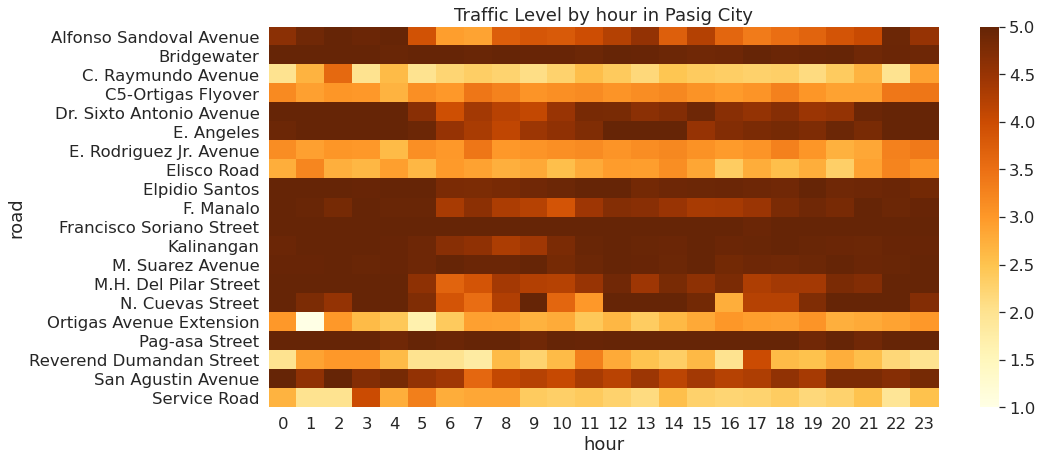

In [86]:
hourly_heatmap(merged_df)

### VIII. A.2 Weekend vs Weekday Traffic Level per hour (Descriptive) 


The average traffic levels between weekdays and weekends differ greatly in the morning. However, both are relatively similar in the afternoon until the early evening. Weekend traffic tends to be worse in the afternoon. This suggests that leisure or household activity is high on the weekend afternoons. These activities are normally missed on weekdays, such as going to the mall or church, running errands, or trips out of town. 

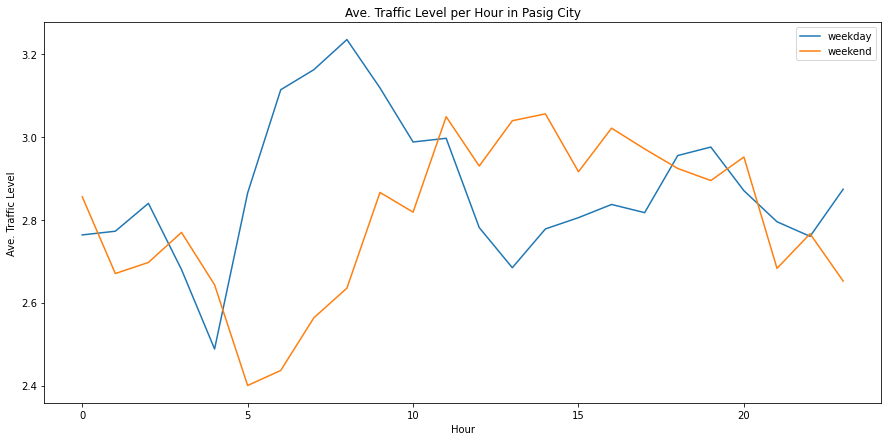

In [68]:
plot_traffic()

### VIII.B. On Weather

#### 1. Histogram of Rainfall Levels

- We plotted a histogram showing the frequency of various levels of rainfall.

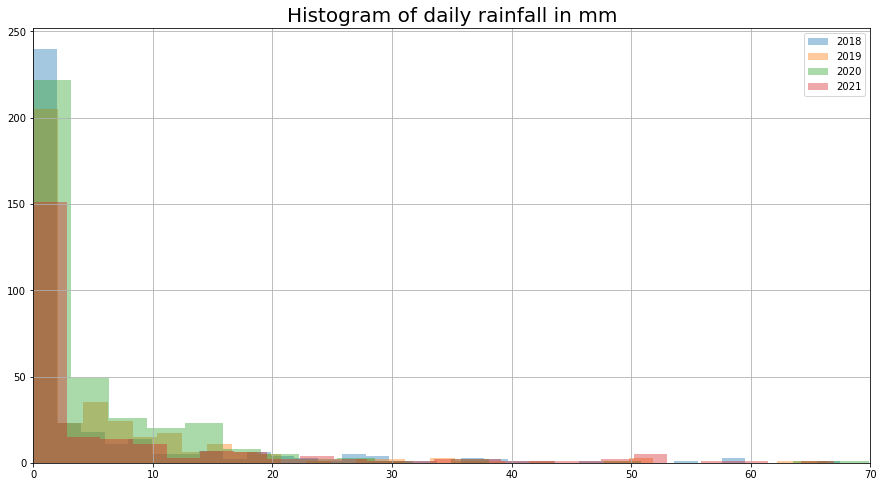

In [27]:
plot_hist_rain()

#### 2. Frequency of Rain Classification Annually

- We also checked the frequency of each classification of rain per year

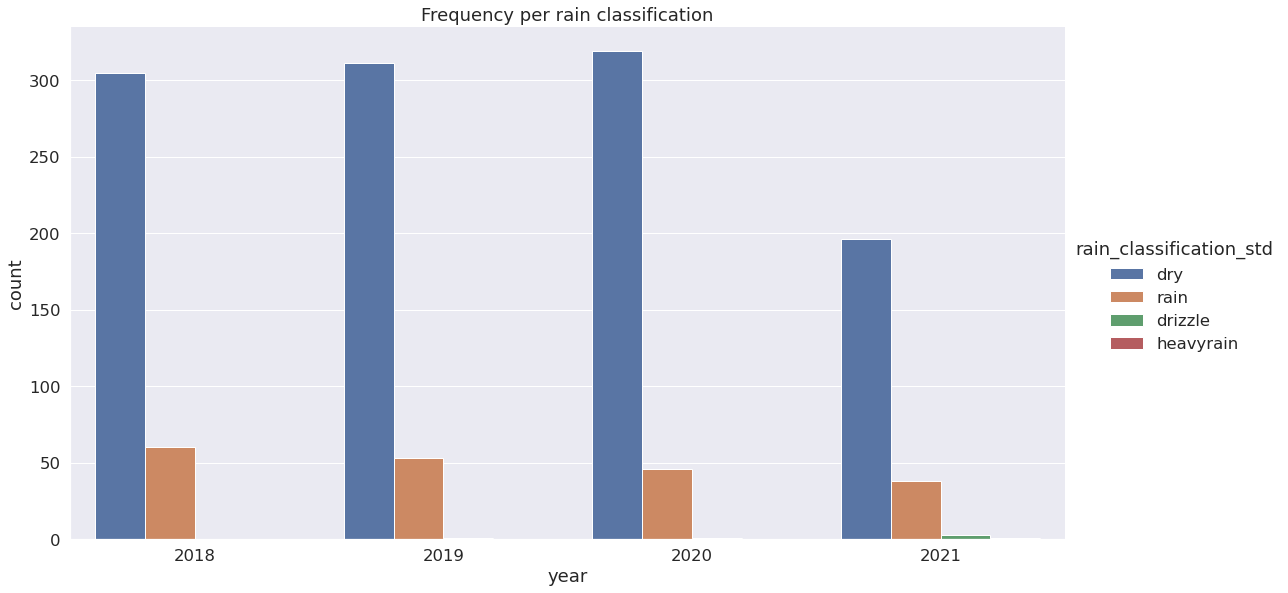

In [81]:
plot_rain_classification()

#### 3. Rainfall Levels for Each Month

- Lastly, we plotted the rainfall levels for each month.

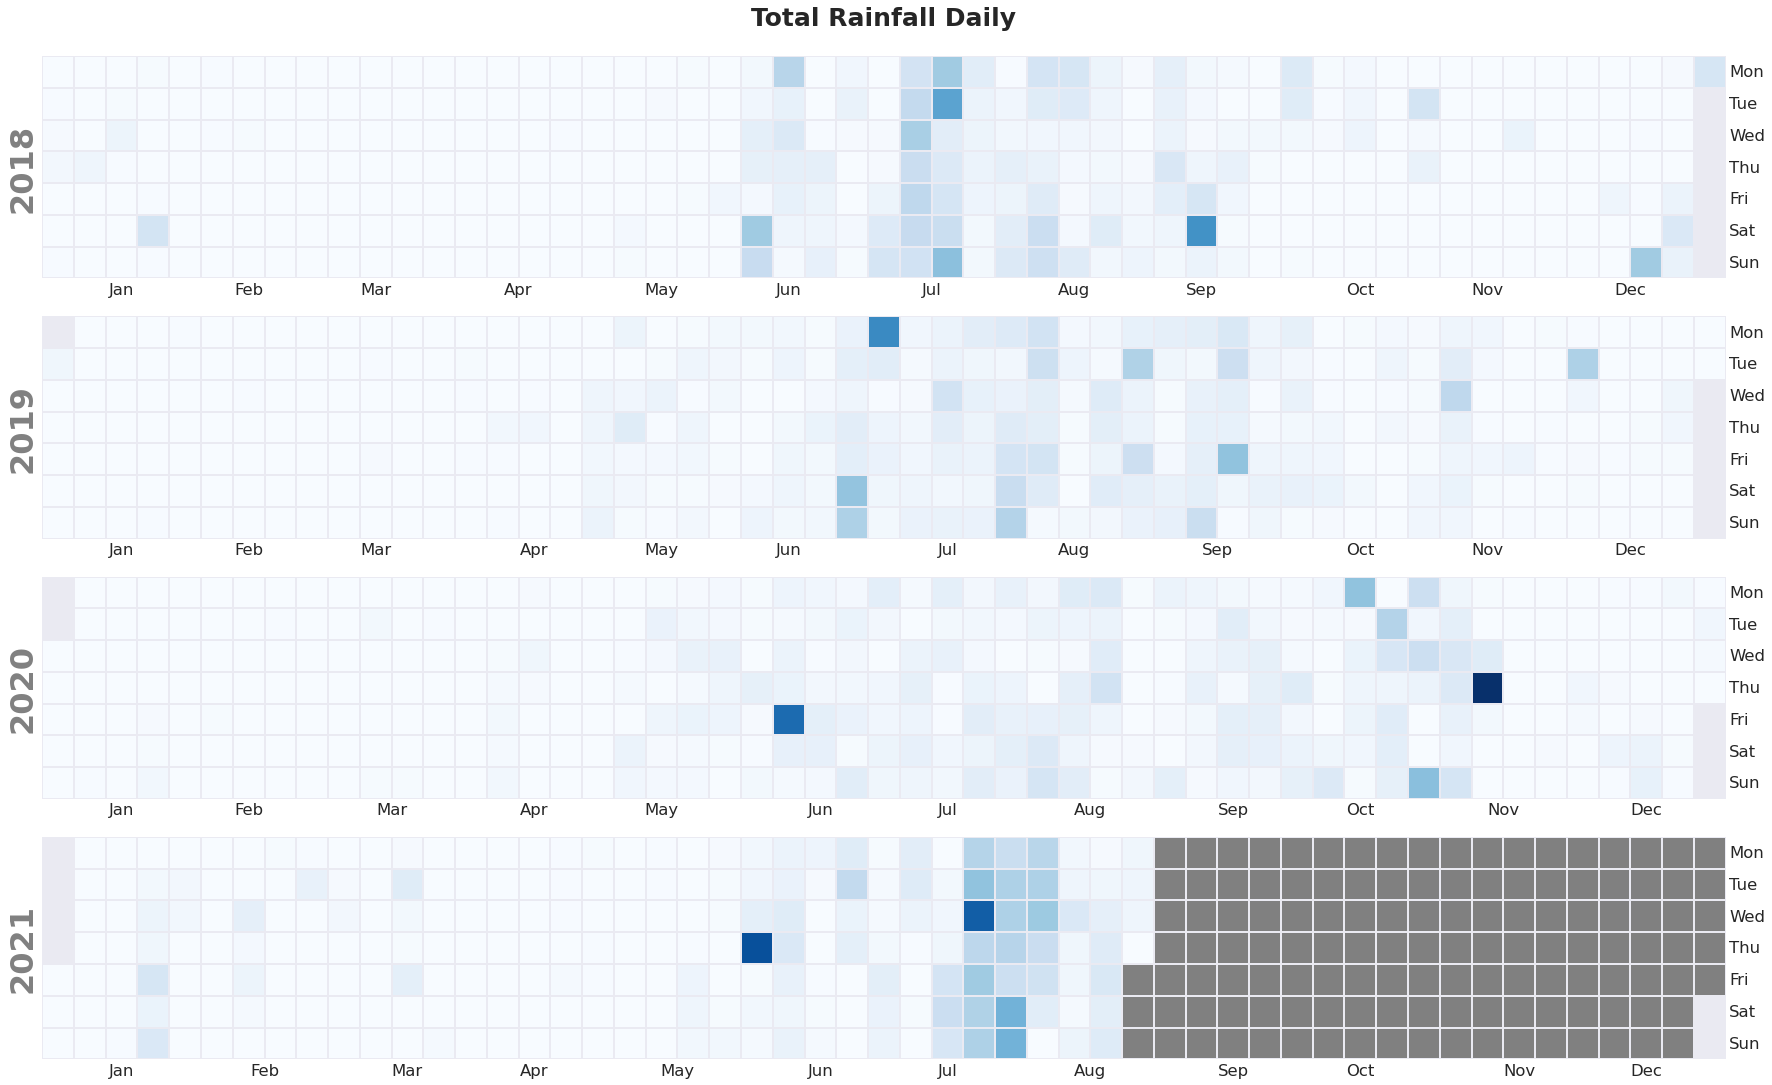

In [109]:
plot_calendar_rain()

### VIII.C. On Traffic’s Response to Weather

#### 1. Scatter Plot due to Heavy Weather

The scatter plot shows the roads in Pasig City that experienced traffic congestion during normal rain. These are some of the roads that are affected by Level 4 Traffic or intense traffic: Pasig Boulevard, C. Raymundo Avenue, Danny Floro Street, Pearl Drive, Exchange Road, Ortigas Avenue and Ortigas-C5 Flyover. While these are the roads that are affected by Level 1 Traffic or light traffic: C. Raymundo Avenue corner Glorietta Street and Pasig Boulevard near Kawilihan Lane.

In [40]:
geo_plot(merged_df, 'Scatter')

#### 2. Heatmap of Traffic Level during Heavy Weather

The heatmap shows the areas of Pasig City that have traffic congestion during normal rain. Some notable areas affected by high traffic congestion are Ortigas, San Antonio, Kapitolyo, Bagong Ilog, Maybunga and Santa Lucia.

In [41]:
geo_plot(merged_df, 'Heatmap')

#### 3. Changes on Speed during Rainy Weather

The map below shows the areas in Pasig City that experience changes in the speed of vehicles during rainy and dry weather. Some notable areas are Ortigas, San Antonio, and Kapitolyo which are similar with areas that have high traffic congestion. This means that the speed of vehicles is much lower in high traffic congested areas.


In [103]:
mapper_dry_vs_rainy(feature_compare='jam_speed_mean',
                    feature_plot='change_due_to_rain')

# IX. Clustering


### XI.A Load dataset and impute missing values

- We load the dataset containing the city blocks' traffic response to weather features. Some city blocks had missing values for certain features, which suggest no jams were reported to Waze. Thus, we impute zero for jam or delay-related features and max for speed-related features. 

In [43]:
#load dataset
blocks2 = pd.read_csv('blocks_df.csv')
df_weather = pd.read_csv('features_weather_new.csv.gz'
                         ,index_col='Unnamed: 0')
#impute missing values
all_features = df_weather.copy()

zero_cols = ['num_jams', 'delay_mean', 'jam_speedxdelay',
             'jam_level_mean', 'delay_sum', 'jam_level_mean']

for col in all_features.columns:
    if any(col.startswith(i) for i in zero_cols):
        all_features[col] = all_features[col].fillna(0)
        
all_features = all_features.fillna(all_features.max())

In this section, we discuss the clustering results of the study. Several clustering methods were explored such as K-Means, Agglomerative, and Ward's Method. While results across these methods were similar, the group decided to choose the Ward's method for easier visualization and interpretability of the clustering process. 

Hierarchical clustering connects pairs of clusters until the hierarchy contains every data object. The number of k-clusters is not pre-defined but is set after analysis depending on the dendogram or hierarchy. The Ward's method is an example of a hierarchical clustering method that prefers to merge the smaller of two pairs of clusters with evenly spaced-centers. It has the following distance metric between two clusters, $A$ and $B$, with an objective to minimize the growth of $ \Delta : $  

$$
\Delta(A, B) = \sum_{i \in A \bigcup B} \|x_i - m_{A \bigcup B}\|^2 - \sum_{i \in A} \|x_i - m_A\|^2 - \sum_{i \in B} \|x_i - m_B\|^2
$$


### XI.B.1 Plot dendogram

- The dataset is scaled prior to performing Ward's Method. We plot the dendogram below which shows 3 distinct clusters.  

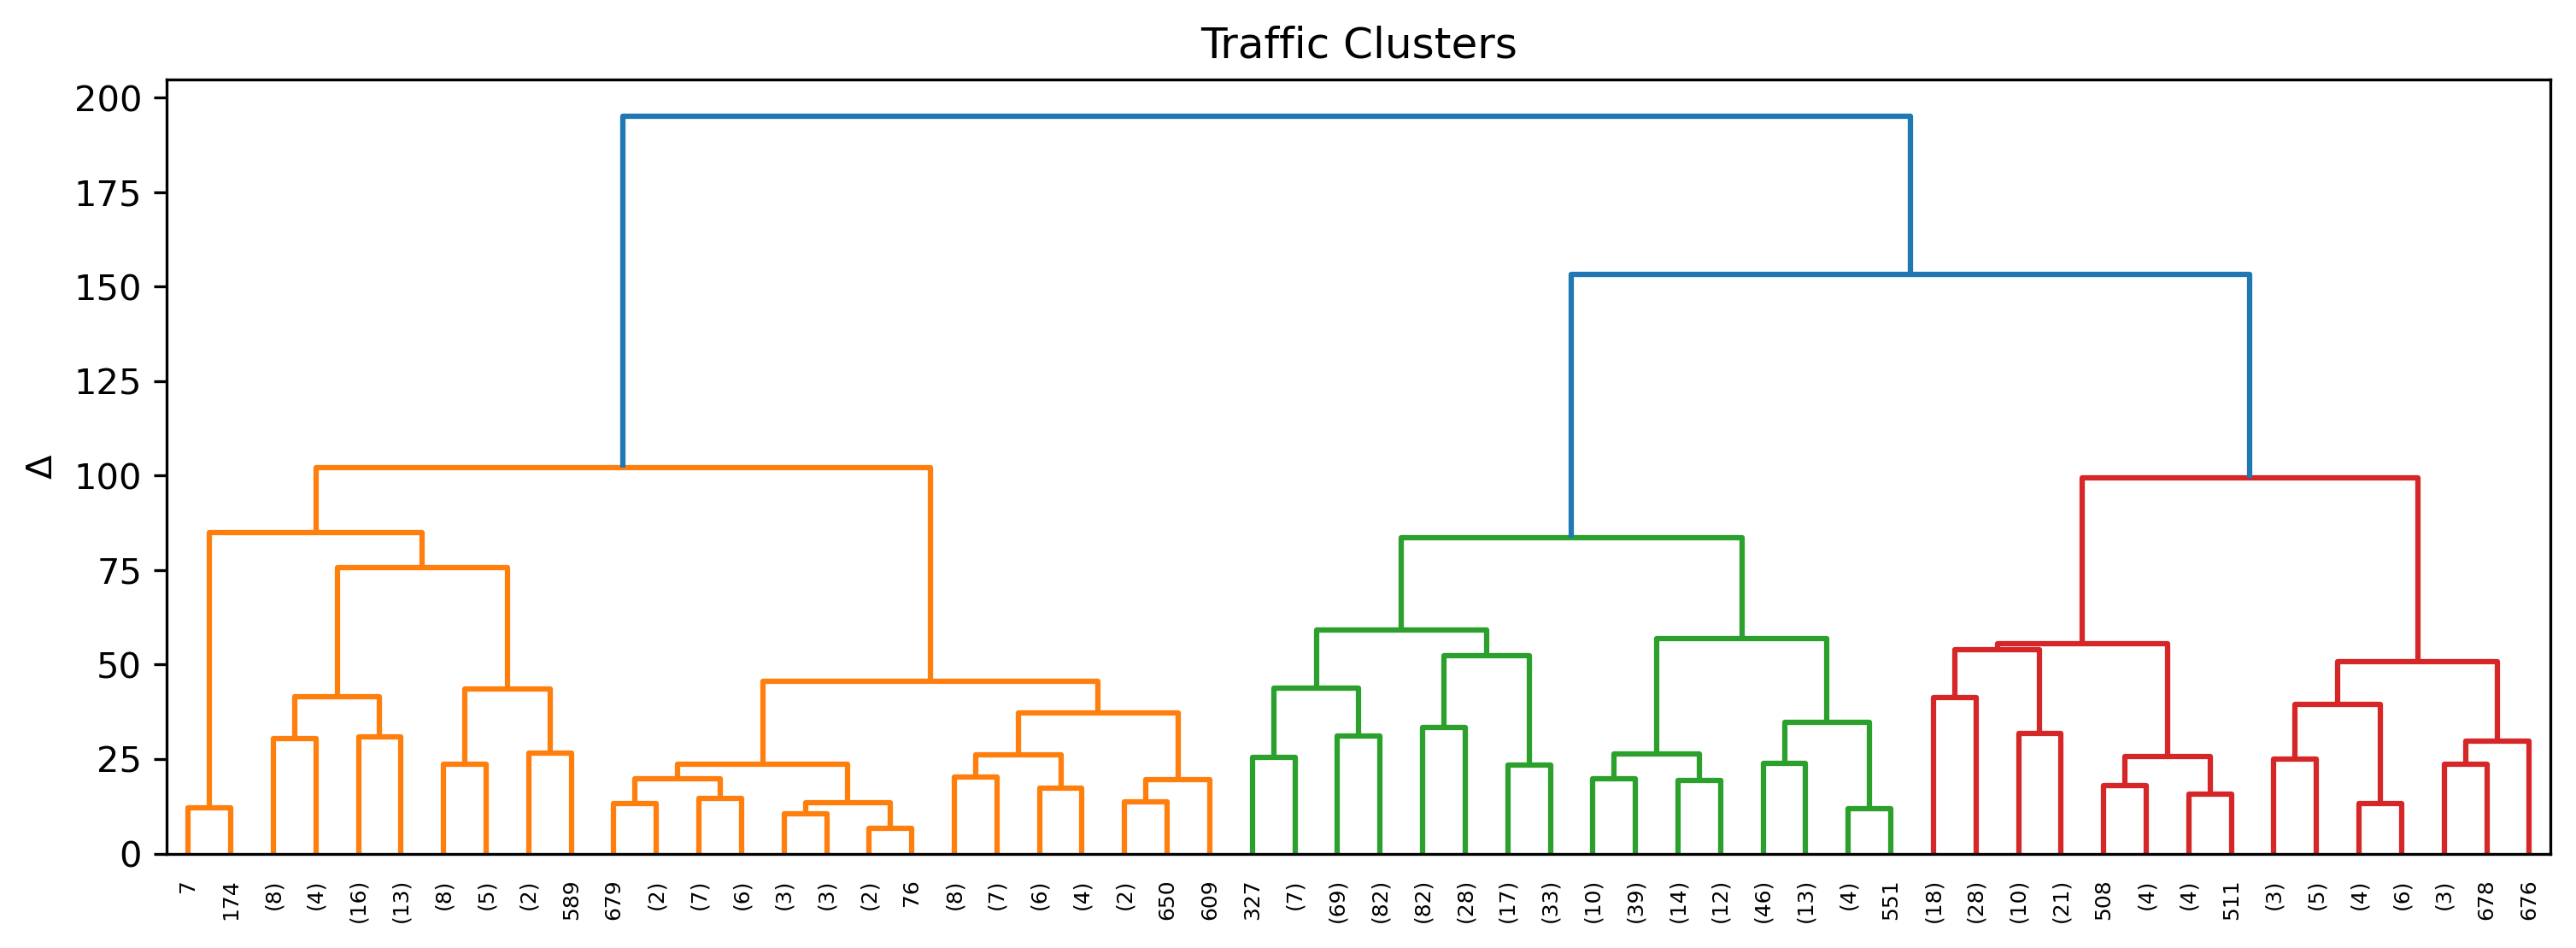

In [53]:
scaler = StandardScaler()
df_weather_scaled = scaler.fit_transform(all_features)
df_weather_scaled = pd.DataFrame(df_weather_scaled, 
                                 columns=all_features.columns, 
                                 index=all_features.index)

Z = linkage(df_weather_scaled, method='ward', optimal_ordering=True)
plot1(Z);

### XI.B.2 Set threshold and perform SVD to plot against SV1 and SV2

Based on the dendogram above, the biggest delta gap is from 100 to 150. No merging of clusters is happening in this interval, signifying significant difference among clusters. Thus, we set the threshold at this range to arrive at 3 defined clusters. 

To evaluate the results of the cluster, we plot it against the first 2 components of SVD. We see that the clusters are separated with minimal overlap, suggesting good results. 

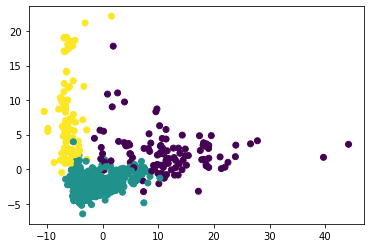

In [59]:
svd = TruncatedSVD(n_components = 2,random_state=716, 
                              n_iter=10)
df_weather_new = svd.fit_transform(df_weather_scaled.fillna(0))
blocks2['cluster'] = fcluster(Z, t=120, criterion='distance')
plt.scatter(df_weather_new[:,0], df_weather_new[:,1], c=blocks2.cluster);

### XI.B.3 Plot against city map

We plot the city blocks based on its cluster for visualization. We clearly see patterns from the clustering. 

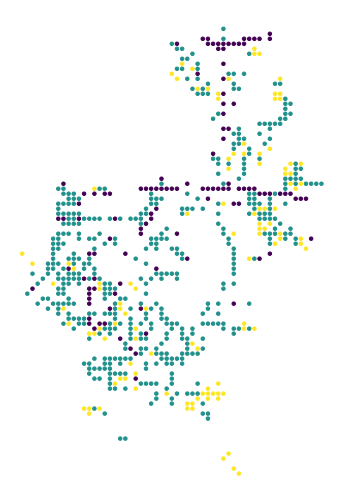

In [60]:
plt.scatter(blocks2.lon, blocks2.lat, s=12, alpha=1, c=blocks2.cluster)
plt.gcf().set_size_inches(5.9, 9)
plt.axis('off');

### XI.B.4 Identify important features via SVD for interpretation of clusters

Since we have 132 features, we rely on the principles of dimensionality reduction to aid in our interpretation of the clusters. We identify the features that contribute the most or have the highest weight against the first component of SVD. These features would explain the most variance across clusters. We list the top 50 features below.

Based on the results, the important features are the following:
* jam_speedxdelay across weather patterns
* jam_speed_max across weather patterns
* jam_speed_std across weather patterns
* delay_sum across weather patterns
* num_of_jams across weather patterns
* jam_speed_mean

These features relate to the amount of congestion based on total delay and number of jams, and traffic behavior based on maximum, average, and standard deviation of jam speed across weather patterns.

In [61]:
featimp = df_weather_scaled.columns[
    np.argsort(np.abs(svd.components_[0]))[::-1]].tolist()
featimp[:50]

['jam_speedxdelay_rain:heavyrain 6hr',
 'jam_speed_max_rain:dry 6hr',
 'jam_speed_max_rain:dry 3hr',
 'jam_speed_max_rain:dry',
 'jam_speedxdelay_rain:heavyrain 3hr',
 'jam_speed_max_rain:drizzle 3hr',
 'jam_speed_max_rain:drizzle 6hr',
 'jam_speedxdelay_rain:dry',
 'jam_speedxdelay_rain:dry 3hr',
 'jam_speedxdelay_rain:dry 6hr',
 'jam_speedxdelay_rain:drizzle 6hr',
 'jam_speedxdelay_rain:drizzle 3hr',
 'jam_speedxdelay_rain:drizzle',
 'jam_speedxdelay_rain:rain',
 'jam_speedxdelay_rain:rain 3hr',
 'jam_speedxdelay_rain:rain 6hr',
 'jam_speed_max_rain:drizzle',
 'jam_speed_std_rain:dry',
 'jam_speed_std_rain:dry 3hr',
 'jam_speed_std_rain:dry 6hr',
 'jam_speed_std_rain:drizzle 6hr',
 'jam_speedxdelay_rain:heavyrain',
 'jam_speed_std_rain:drizzle 3hr',
 'delay_sum_rain:rain 6hr',
 'delay_sum_rain:drizzle',
 'delay_sum_rain:rain 3hr',
 'delay_sum_rain:drizzle 3hr',
 'delay_sum_rain:rain',
 'delay_sum_rain:heavyrain',
 'delay_sum_rain:drizzle 6hr',
 'delay_sum_rain:heavyrain 6hr',
 'delay

### XI.B.5 Plot histogram for `delay_per_length_max` across clusters

While the `delay_per_length_max` was not considered a top feature along SV1, this measures the maximum normalized delay. This allows us to understand how badly congested the areas can get, highlighting the need for better infrastructure capacity. We plot a histogram per cluster at a city block level below based on dry weather since this is the most prominent weather pattern.

We see that Cluster 3 has the lowest mean normalized delay, with most city blocks along very low levels of normalized delay. Thus, the worst congestion level along these areas may be deemed tolerable. On the other hand, most city blocks in Cluster 1 and 2 have high levels of normalized max delay, suggesting that a lot of areas can get extremely congested. 

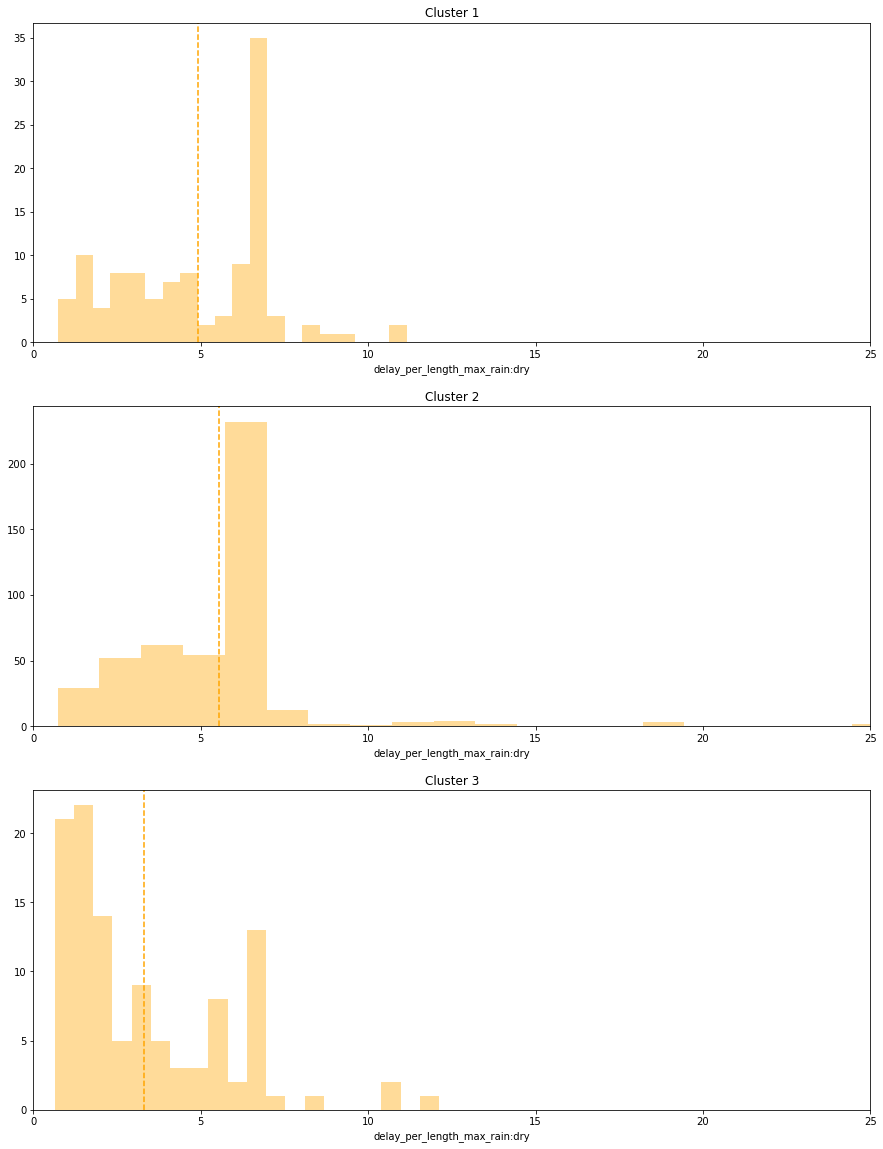

In [62]:
df_weather_merge = blocks2[['coords', 'cluster']].merge(df_weather, 
                                                       left_on = 'coords', 
                                                       right_index = True)
df_delay_per_length = df_weather_merge[['cluster', 
                                        'delay_per_length_max_rain:dry']]

f, axes = plt.subplots(3, 1, figsize=(15, 20))
for ax, cluster in zip(axes.flat, [1,2,3]):
    ax.set_title(f"Cluster {cluster}", 
                 fontsize = 12)
    delay = (df_delay_per_length[df_delay_per_length.cluster == 
                                cluster]['delay_per_length_max_rain:dry'])
    g = sns.distplot(delay, kde=False, bins=20, color="orange", 
                 hist_kws=dict(alpha=0.4), ax=ax)
    mean = delay.mean() #change to feature
    ax.axvline(x=mean, color='orange', linestyle='--') 
    g.set(xlim=(0, 25))
plt.show()

# X. Results and Discussion 

### X.A Interpret clusters

We list the top 50 features based on SV1 per cluster basis by obtaining the mean.


In [63]:
df_weather_merge = blocks2[['coords', 'cluster']].merge(df_weather, 
                                                       left_on = 'coords', 
                                                       right_index = True)
df_weather_merge = df_weather_merge.groupby('cluster').mean().T
df_weather_merge.astype(float).round(2).loc[featimp[:50]]

cluster                                       1           2         3
jam_speedxdelay_rain:heavyrain 6hr       771.05      246.10    126.36
jam_speed_max_rain:dry 6hr                 7.80        3.48      1.84
jam_speed_max_rain:dry 3hr                 7.82        3.49      1.86
jam_speed_max_rain:dry                     7.84        3.50      1.88
jam_speedxdelay_rain:heavyrain 3hr       745.31      235.08    106.04
jam_speed_max_rain:drizzle 3hr             7.78        3.44      1.72
jam_speed_max_rain:drizzle 6hr             7.78        3.44      1.74
jam_speedxdelay_rain:dry                 759.64      245.39    164.76
jam_speedxdelay_rain:dry 3hr             756.68      244.85    164.69
jam_speedxdelay_rain:dry 6hr             752.69      244.15    165.25
jam_speedxdelay_rain:drizzle 6hr         805.84      250.78    162.82
jam_speedxdelay_rain:drizzle 3hr         815.83      251.36    155.90
jam_speedxdelay_rain:drizzle             822.85      251.50    155.38
jam_speedxdelay_rain:rain                831.84      254.16    143.15
jam_speedxdelay_rain:rain 3hr            828.57      254.04    148.81
jam_speedxdelay_rain:rain 6hr            849.02      255.34    150.92
jam_speed_max_rain:drizzle                 7.75        3.42      1.69
jam_speed_std_rain:dry                     1.42        0.56      0.33
jam_speed_std_rain:dry 3hr                 1.42        0.56      0.32
jam_speed_std_rain:dry 6hr                 1.41        0.56      0.32
jam_speed_std_rain:drizzle 6hr             1.44        0.57      0.30
jam_speedxdelay_rain:heavyrain           839.57      230.65     99.04
jam_speed_std_rain:drizzle 3hr             1.44        0.57      0.29
delay_sum_rain:rain 6hr              3073728.57   339198.52   4073.54
delay_sum_rain:drizzle               8973275.03  1028817.56  12205.50
delay_sum_rain:rain 3hr              1850082.53   202898.56   2665.95
delay_sum_rain:drizzle 3hr           9755543.57  1145012.34  13380.64
delay_sum_rain:rain                   677456.25    73677.65   1083.61
delay_sum_rain:heavyrain               75894.41     7608.44   1209.25
delay_sum_rain:drizzle 6hr          10023535.37  1210364.20  14596.39
delay_sum_rain:heavyrain 6hr          411961.13    49369.88    772.62
delay_sum_rain:heavyrain 3hr          175170.98    19650.43    446.00
delay_sum_rain:dry                  22311173.35  2932640.47  41767.36
num_jams_rain:rain 3hr                 52706.62     9607.95    147.86
delay_sum_rain:dry 6hr              18513463.44  2442964.29  35712.14
delay_sum_rain:dry 3hr              20249097.06  2674335.55  38598.09
num_jams_rain:rain 6hr                 84056.50    15453.40    221.79
jam_speed_max_rain:rain 6hr                7.46        3.26      1.49
num_jams_rain:drizzle                 266189.88    48426.29    700.27
num_jams_rain:heavyrain 6hr            12998.71     2443.32     49.17
jam_speed_mean_rain:dry 6hr                3.13        1.65      1.13
jam_speed_std_rain:drizzle                 1.44        0.57      0.29
jam_speed_mean_rain:dry 3hr                3.12        1.65      1.13
num_jams_rain:rain                     19117.29     3435.58     58.22
jam_speed_mean_rain:dry                    3.11        1.64      1.13
num_jams_rain:drizzle 3hr             289482.48    53254.88    771.67
num_jams_rain:heavyrain 3hr             6092.53     1029.07     28.57
num_jams_rain:drizzle 6hr             299939.04    55901.99    844.26
num_jams_rain:dry 6hr                 584568.64   115975.74   1983.93
num_jams_rain:dry                     694217.77   137548.52   2332.80

### Cluster 1: Main Highways

1. These areas promise you the fastest route with highest maximum and average speed, but a lot will find themselves very delayed in times of congestion due to vehicular volume and its long stretch. There is a high risk, high reward tradeoff along these areas, highlighted by the very high standard deviation of jam speed. Thus, it may be recommendable for drivers to traverse these routes only when there is no congestion. The traffic behavior across different weather patterns remains consistent for the cluster. We list them as follows:
> * Highest number of jams 
> * Highest standard deviation of jam speed
> * Highest fastest jam speed
> * Highest average jam speed
> * Second highest max normalized delay
> * Second highest slowest speed

2. Major highways fall under this cluster. Notable areas include Ortigas Ave. Extension, Marcos Highway, E. E. Rodriguez Jr. Ave, Amang Rodriguez Ave, and Ortigas Ave.


3. These are areas in need of immediate improvements in infrastructure capacity given significant number of jams reported, signalling high utilization of routes and high level of congestion. 

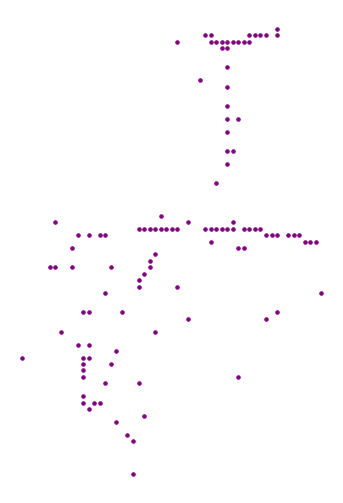

In [64]:
plt.scatter(blocks2[blocks2.cluster == 1].lon, 
            blocks2[blocks2.cluster == 1].lat, 
            s=12, alpha=1, color = 'purple')
plt.gcf().set_size_inches(5.9, 9)
plt.axis('off');

### Cluster 2: Intracity Routes

1. These routes are mostly ranked second across delay, jams, and speed features in response to weather. These areas can be very congested as well given significant max normalized delay and number of jams reported. Unlike in Cluster 1 where there is potential for high reward when there is no congestion, low standard deviation, minimum and mean jam speed along these routes suggest that drivers should expect general slowdown in these areas. The traffic behavior across different weather patterns remains consistent for the cluster. We list them as follows:

> * Highest max normalized delay
> * Second highest number of jams
> * Second highest standard deviation
> * Second highest fastest speed
> * Second highest mean jamp speed
> * Second highest standard deviation of jam speed
> * Lowest slowest jam speed

2. Most areas in Pasig fall under this category, suggesting the city’s general congested state. Notable areas include Elisco Road, Doña Julia Vargas Ave., Jenny’s Ave, Meralco Ave, and Dr. Sixto Antonio Ave.



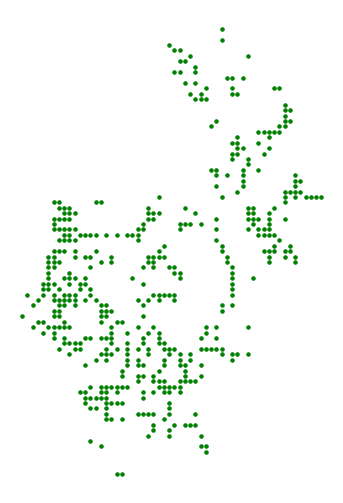

In [65]:
plt.scatter(blocks2[blocks2.cluster == 2].lon,
            blocks2[blocks2.cluster == 2].lat, 
            s=12, alpha=1, color = 'green')
plt.gcf().set_size_inches(5.9, 9)
plt.axis('off');

### Cluster 3: Hidden Routes

1. These routes do not seem promising given lowest max and mean speed in the area, but these are your smoothest routes with least congestion. With the highest slowest speed, these routes are recommended for drivers who would rather move at a slower pace than find themselves stuck. Traffic behavior along this area is very predictable given lowest level of standard deviation of jam speed and max normalized delay. The traffic behavior across different weather patterns remains consistent for the cluster. We list them as follows:
> * Lowest number of jams
> * Lowest max normalized delay
> * Lowest fastest speed
> * Lowest mean speed
> * Lowest standard deviation in jam speed
> * Highest slowest speed

2. These lie mostly in the outskirts of Pasig City. Notable areas include Axis Road, Samama Napindan Road, Daang Manunuso, Ipil, B. Tatco.


3. The number of jams reported is extremely low relative to the other 2 clusters. The max normalized delay is also lowest in these areas. Thus, in times of congestion, traffic is still manageable. This suggests that these areas have the capacity to accommodate more vehicles. These are areas MMDA and Waze can redirect vehicles to in times of congestion or bad weather. 

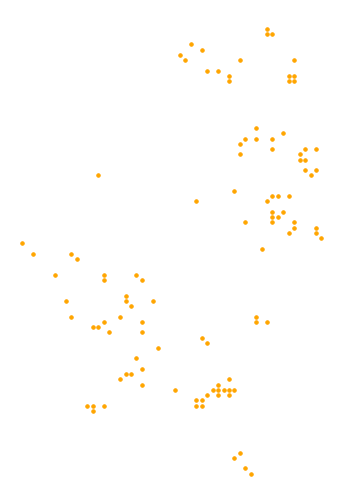

In [66]:
plt.scatter(blocks2[blocks2.cluster == 3].lon, 
            blocks2[blocks2.cluster == 3].lat, 
            s=12, alpha=1, color = 'orange')
plt.gcf().set_size_inches(5.9, 9)
plt.axis('off');

### X.B Clustering Attempt for Multiple Feature Engineered Dataset.

The initial methodology was to reduce the combined dataset with engineered features which had high dimensionality using Principal Component Analysis and apply some form of clustering after. Due to the imbalance of engineered features from each dataset, the traffic dataset dominated the resulting clusters and engineered features from weather were not present. Thus, the results were inconclusive and the methodology was revised to the one used now. These results were still included in the report under Appendix A.

# XI. Conclusion

The study entailed several steps from web scraping to vectorizing traffic data to performing feature engineering. With data vectorization, we were able to create a more consistent dataset which enabled us to perform the necessary analysis. Together with feature engineering, we were then able to extract more information that was not inherent in our raw data. 

We then performed several clustering methods to interpret the data. These methods included K-Means and Agglomerative Methods, but we chose Ward’s Method for its easier visualization and interpretability of the clustering process. 

The results showed three distinct clusters which were intuitive when plotted onto a map. To ease our interpretation of the clusters given 132 features, we evaluated the top features based on the first component of SVD. Below are the top features which we relied on to explain the difference across clusters:

* jam_speedxdelay across weather patterns
* jam_speed_max across weather patterns
* jam_speed_std across weather patterns
* delay_sum across weather patterns
* num_of_jams across weather patterns
* jam_speed_mean

These features relate to the amount of congestion based on total delay and number of jams, and traffic behavior based on maximum, average, and standard deviation of jam speed across weather patterns.

The clusters that emerged from the study were able to unveil the different areas of congestion in the city. Notably, one cluster consisted of routes that experienced the worst traffic jams despite its promise of faster accessibility across the city. We labeled these routes as the Main Highways because it included roads such as Ortigas Avenue. In addition, the clusters also pinpointed routes that were less likely to experience congestion but had the slowest speeds for traversing cars. We labeled these routes as Hidden Routes due to a lack of traffic jams but had more consistent vehicular flow. Lastly, we had the Intracity Routes which experienced the worst congestion and lowest maximum speeds. These routes were typically round shopping and business districts in Ortigas Center. 

# XII. Recommendation

### A. For the relevant stakeholders:
Given our study’s results, we have three main recommendations. First, there should be significant priority in managing the traffic jams in Cluster 1, which we identified as the Main Highways. These routes are predictably the biggest thoroughfares which are C5 (E. Rodriguez Avenue) and Ortigas Avenue. We further recommend increasing infrastructure capacity to address the congestion. 

Second, to considerably ease the burden on the Main Highways, we also recommend rerouting traffic to the less-utilized roads (Hidden Routes) during rush hour. These routes may have low maximum speeds compared to the other roads in the city, but these are less susceptible to choking and the eventual traffic jams. 

Third, our largest cluster was the Intracity Routes which had the highest normalized delays among the clusters. We believe this is where long-term urban planning policies may provide more effective traffic management. The cluster tends to highlight several points of interest, such as shopping malls, business districts, and institutional facilities. There could be room for more effective public transport options or routes. We expect such policies could ease traffic volumes within the city.

### B. For further studies:
This study could also have benefitted from bashing the two datasets with actual records of flood reports from Waze alerts, but we were not able to successfully request the alerts table from Thinking Machines. Similar data and other details such as accidents could also be scraped from Twitter or news reports but would require some NLP.

Waze only records areas with jams, defined as moments when the average speed slows down to less than 80% of freeflow speed. To get a more representation of ground truth, each segment of road that is not jammed must be filled in with the freeflow speed. However, this is algorithmically complex and would bump up our dataset to dozens of GB and is outside the scope of this subject.

# Acknowledgements:

1. Prof. Christian Alis - For the mentorship and guidance in DMW.
2. Waze and Thinking Machines - For providing us with the traffic dataset used in the study.

# References:

1. "Machine Learning and AI via Brain simulations". Stanford University. Retrieved 2019-08-01.
2. Waze. Traffic Data Specification Document. Version 2.8. p15. 2017 March.
3. Géron, A. (2020). Main Challenges of Machine Learning. Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems (p. 69). O’Reilly.

# Appendix

The original methodology planned on using the dataset with 2059 total features. We first applied dimensionality reduction to determine the minimum number of features to explain at least 90% of the variance. 125 principal components were needed for this from the 2059 features, with the first principal component reaching about 45%. The initial dimensionality reduction technique used was Principal Component Analysis rather than Singular Value Decomposition. SVD is more suited for sparse data and at this point, the 2059 total features have about 10% zero values from imputing NaN values. For our current methodology however, we believed this was not enough for the dataset to be considered a sparse matrix and that SVD would still be more appropriate in performing the dimensionality reduction. After this, we proceeded in using a clustering technique each from representative and hierarchical methods. Kmeans clustering was preferred with its internal validation checks and low cost of implementation. Plotted on the first and second PCA, these were the clustering results.

#### Figure A.1. Clustered blocks plotted on the first and second principal components.

The resulting clusters when plotted on the map of Pasig yielded a great visual representation of the clusters eventually led us to use this algorithm on the cluster results in our current methodology.

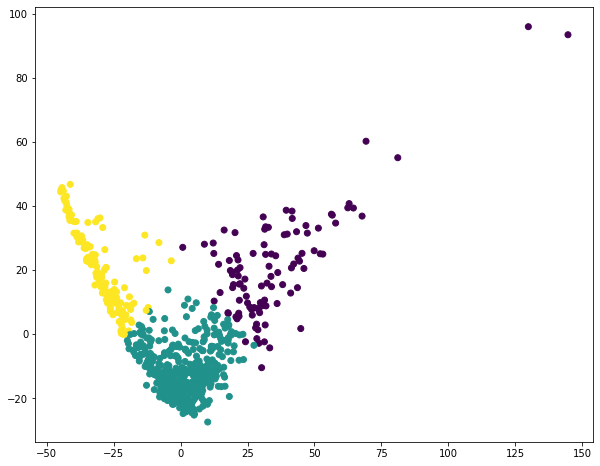

In [91]:
Image('Appendix_A1.png')

#### Figure A.2. Clustered points plotted on coordinates. Purple colors represented the main road network.


However, when exploratory data analysis was done on the clusters and the principal components, the results were inconclusive to our problem statement as most of the weather-related features were no longer present in the principal components. The clusters themselves were lacking in differences when interpreting points of interest on the map especially if the three clusters were close together. The principal components failing to yield weather data was our biggest crutch as we could not provide any means to relate weather and traffic. Thus, the need for revision in our methodology.

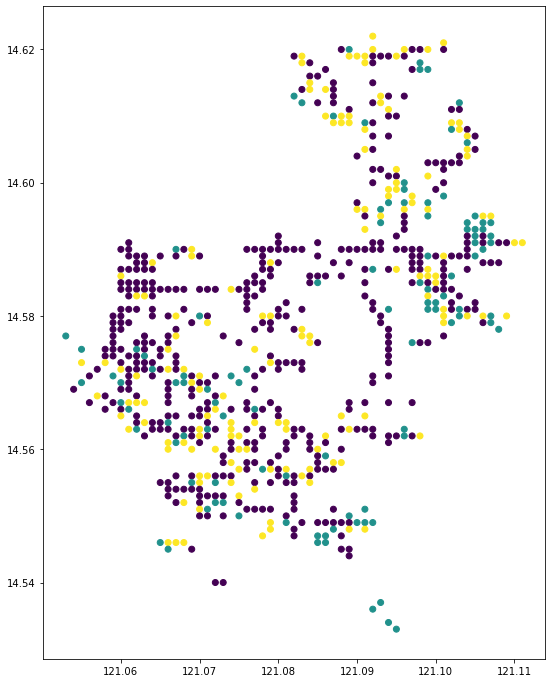

In [93]:
Image('Appendix_A2.png')